In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use('seaborn-v0_8-poster')


In [2]:
def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def _draw_sig_line(ax, x1, x2, y, text, h=0.03):
    """Draw a flipped (downward) significance bracket below bars."""
    ax.plot((x1, x1, x2, x2),
            (y, y - h, y - h, y),
            lw=1.5, color="black", clip_on=False)
    if text:
        ax.text((x1 + x2) / 2.0, y - h * 1.2, text,
                ha="center", va="top",
                fontsize=14, fontweight="bold", color="black")


def get_matching_model_terms(model, variable):
    """
    Return model term names from model.params.index that match `variable`.

    Behavior:
    ----------
    - If `variable` has no ':' or '*' → return only main-effect terms
      (e.g., 'Group' → ['Group[T.HC]'])
    - If `variable` includes ':' or '*' → return exact interaction terms
      (e.g., 'Group:Drug' → ['Group[T.HC]:Drug[T.Placebo]'])
    - If `variable` == 'two_way' → return *all* 2-way interactions
      (useful in 3-factor models like Group * Drug * Gender)
    - If `variable` == 'three_way' → return *all* 3-way interactions

    Example model.params.index:
      ['Intercept',
       'Group[T.HC]',
       'Drug[T.Placebo]',
       'Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]',
       'Group[T.HC]:Gender[T.Female]',
       'Drug[T.Placebo]:Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]']
    """
    # Remove intercept
    params = [p for p in model.params.index if p.lower() != "intercept"]

    # === Case 1: Request all 2-way interactions ===
    if variable.lower() == "two_way":
        return [p for p in params if p.count(":") == 1]

    # === Case 2: Request all 3-way interactions ===
    if variable.lower() == "three_way":
        return [p for p in params if p.count(":") == 2]

    # === Case 3: Single factor → main effects only ===
    if (":" not in variable) and ("*" not in variable):
        factor = variable
        return [p for p in params if p.startswith(factor + "[") and (":" not in p)]

    # === Case 4: Specific interaction (2-way or 3-way) ===
    var = variable.replace("*", ":")
    factors = [f for f in var.split(":") if f]

    out = []
    for p in params:
        # must have correct interaction order
        if p.count(":") != (len(factors) - 1):
            continue
        # must include all specified factors
        if all((f + "[") in p for f in factors):
            out.append(p)

    return out



def extract_factors_from_term(term):
    """
    Extract base factor names (e.g., 'Group', 'Drug', 'Gender') 
    from a statsmodels term like:
        'Group[T.HC]:Drug[T.Placebo]'  → ['Group', 'Drug']
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
        'Group[T.HC]' → ['Group']

    Works for both main and interaction terms.
    """
    # Split by ':' to separate interaction components
    parts = term.split(":")
    # For each part, take everything before the first '['
    factors = [p.split("[")[0] for p in parts]
    return factors

In [3]:
def add_sig_stars(ax, df, roi_list, variable, pad_frac=0.1, hue_order=None):
    """
    Generalized version that supports 2-way, 3-way, or higher-order interactions.

    Prints:
      1. Model result (ROI, variable, β, t, df, p)
      2. One-sample t-tests (ROI, factor level, mean, t, df, p)
    Adds * to bar plot for significant results.

    Automatically reads model factors from 'variable'.
    e.g. variable='Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → model='Z_score ~ Group * Drug * Gender'
    """

    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    is_interaction = ":" in variable

    # === Parse model factors dynamically ===
    # Example: 'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors)

    print(f"\nModel results ({formula})")
    print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
    print("-" * 100)

    # === Table 1: Model results ===
    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # 🔹 Dynamically specified model
        model = smf.ols(formula, data=df_roi).fit()

        if variable not in model.params.index:
            continue

        beta = model.params[variable]
        tval = model.tvalues[variable]
        pval = model.pvalues[variable]
        dfree = int(model.df_resid)
        star = significance_marker(pval)

        print(f"{roi:<15} {variable:<50} {beta:>10.3f} {tval:>8.2f} {dfree:>5} {pval:>8.3f} {star:>5}")

        # --- Bar selection per ROI ---
        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]
        if not bars:
            continue

        # --- Draw flipped bracket for significant model effects (main effects only) ---
        if not is_interaction and star:
            bars_sorted = sorted(bars, key=lambda r: r.get_x())
            b1, b2 = bars_sorted[0], bars_sorted[-1]
            x1c = b1.get_x() + b1.get_width() / 2
            x2c = b2.get_x() + b2.get_width() / 2
            x_mid = (x1c + x2c) / 2
            y1 = b1.get_y() + b1.get_height()
            y2 = b2.get_y() + b2.get_height()
            min_y = min(y1, y2)
            y_bracket = min_y - 0.3
            y_star = min_y - 0.4
            _draw_sig_line(ax, x1c, x2c, y_bracket, "", h=y_range * 0.03)
            ax.text(x_mid, y_star, star,
                    ha="center", va="top",
                    fontsize=14, fontweight="bold", color="black")

    print("-" * 100)

    # === Table 2: One-sample t-tests ===
    if is_interaction:
        group_factors = factors
        print(f"ONE-SAMPLE T-TESTS BY INTERACTION LEVEL ({' × '.join(group_factors)})")
    else:
        group_factors = [factors[0]]
        print(f"ONE-SAMPLE T-TESTS BY {group_factors[0].upper()} LEVEL")

    print(f"{'ROI':<15} {'Level':<50} {'Mean':>10} {'t':>8} {'df':>6} {'p':>10} {'Sig':>5}")
    print("-" * 100)

    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]

        # === Main effect ===
        if len(group_factors) == 1:
            factor = group_factors[0]
            if factor not in df_roi.columns:
                continue

            for level, vals in df_roi.groupby(factor, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                label = f"{factor}={level}"
                print(f"{roi:<15} {label:<50} {mean_val:>10.3f} {tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    if hue_order is None:
                        hue_order = list(df[factor].cat.categories)
                    level_to_bar = dict(zip(hue_order, bars))
                    if level in level_to_bar:
                        rect = level_to_bar[level]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

        # === Interaction effect (2-way, 3-way, or higher) ===
        else:
            valid_factors = [f for f in group_factors if f in df_roi.columns]
            if len(valid_factors) < 2:
                continue

            for levels, vals in df_roi.groupby(valid_factors, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                level_labels = "_".join(map(str, levels))
                print(f"{roi:<15} {level_labels:<50} {mean_val:>10.3f} "
                      f"{tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    # Build hue order dynamically based on unique combinations
                    if hue_order is None:
                        hue_order = [
                            "_".join(map(str, combo))
                            for combo in df_roi[valid_factors]
                            .drop_duplicates()
                            .itertuples(index=False, name=None)
                        ]
                    level_to_bar = dict(zip(hue_order, bars))
                    key = "_".join(map(str, levels))
                    if key in level_to_bar:
                        rect = level_to_bar[key]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

    print("-" * 100)


In [4]:
def add_sig_stars_lineplot_interaction(ax, df, roi_list, variable):
    """
    Adds significance stars (***, **, *) to each subplot's title
    if the specified interaction term in `variable` is significant
    for that ROI.

    Automatically supports 2-way, 3-way, or higher-order interactions.
    e.g.:
        'Group[T.HC]:Gender[T.Female]'
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]'
    """

    # Extract main factors from variable (remove duplicates safely)
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors)

    axes = ax.flat if hasattr(ax, "flat") else [ax]

    print(f"\n=== Lineplot significance check for {variable} ===")
    print(f"Model formula: {formula}")
    print(f"{'ROI':<15} {'p-value':>10} {'Sig':>5}")
    print("-" * 35)

    for i, roi in enumerate(roi_list):
        if i >= len(axes):
            break
        ax_i = axes[i]

        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # Dynamically fit model with all relevant factors
        model = smf.ols(formula, data=df_roi).fit()

        # Skip if the term is not part of the model
        if variable not in model.pvalues.index:
            continue

        # Get p-value and significance marker
        pval = model.pvalues[variable]
        star = significance_marker(pval)

        # Update subplot title with star if significant
        current_title = ax_i.get_title()
        new_title = f"{current_title} {star}" if star else current_title
        ax_i.set_title(new_title, fontweight="bold" if star else "normal")

        print(f"{roi:<15} {pval:>10.4f} {star:>5}")

    print("-" * 35)


In [5]:
tasks = ['phase2','phase3']
contrast_list = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
ROI_list = [
        'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
        'VMPFC'
        ]
group_list = [
        'Patient',
        'HC'
        ]
drug_list = ['Oxytocin',
        'Placebo']
gender_list = ['Male', 'Female']

In [6]:
plot_dir_top = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/plots'
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
df_drug_order = pd.read_excel(drug_order_file, 'drug_order')
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI'
first_level_data_file = os.path.join(first_level_dir, 'first_level.csv')
df_fMRI = pd.read_csv(first_level_data_file)
df_merged = pd.merge(df_fMRI, df_drug_order, on='subID', how='left')
df_all = df_merged.rename(columns={
    'Task': 'Phase'
})
df_all.loc[df_all['subID'].str.startswith('N1'), 'Group'] = 'Patient'
df_all.loc[df_all['subID'].str.startswith('N2'), 'Group'] = 'HC'
categorical_cols = ['ROI', 'subID', 'Phase', 'Contrast', 'Group', 'Gender', 'Drug','guess']
df_all[categorical_cols] = df_all[categorical_cols].astype('category')
df_all['Contrast'] = df_all['Contrast'].cat.set_categories(contrast_list, ordered=True)
df_all['ROI'] = df_all['ROI'].cat.set_categories(ROI_list, ordered=True)
df_all['Group'] = df_all['Group'].cat.set_categories(group_list, ordered=True)
df_all['Drug'] = df_all['Drug'].cat.set_categories(drug_list, ordered=True)
df_all['Gender'] = df_all['Gender'].cat.set_categories(gender_list, ordered=True)


In [7]:
print(len(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID'].unique()))
print(len(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID'].unique()))
print(len(df_drug_order['subID'].unique()))

100
101
104


In [8]:
# Subjects in drug order but missing from fMRI data
missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase2: {len(missing_in_fMRI)}")
print(missing_in_fMRI)

missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase3: {len(missing_in_fMRI)}")
print(missing_in_fMRI)
# SUBJECTS_NO_MRI = {
#     'phase2': ['N102', 'N208'],
#     'phase3': ['N102', 'N208', 'N120']
# }
# removing subjects w wrong sequence / missing phases:
# sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3



🧩 Subjects in drug order file but not in fMRI data in phase2: 4
['N101' 'N102' 'N201' 'N208']
🧩 Subjects in drug order file but not in fMRI data in phase3: 3
['N102' 'N120' 'N208']


Extinction

placebo 

In [9]:
plot_dir = os.path.join(plot_dir_top, 'extinction/placebo')
os.makedirs(plot_dir, exist_ok=True)
model = smf.ols("Z_score ~ Group * Gender", data=df_all).fit()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.340     0.99    47    0.327      
Insula          Group[T.HC]                                             0.171     0.45    47    0.657      
Hippocampus     Group[T.HC]                                             0.351     0.88    47    0.384      
ACC             Group[T.HC]                                             0.231     0.67    47    0.507      
VMPFC           Group[T.HC]                                            -0.102    -0.28    47    0.780      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

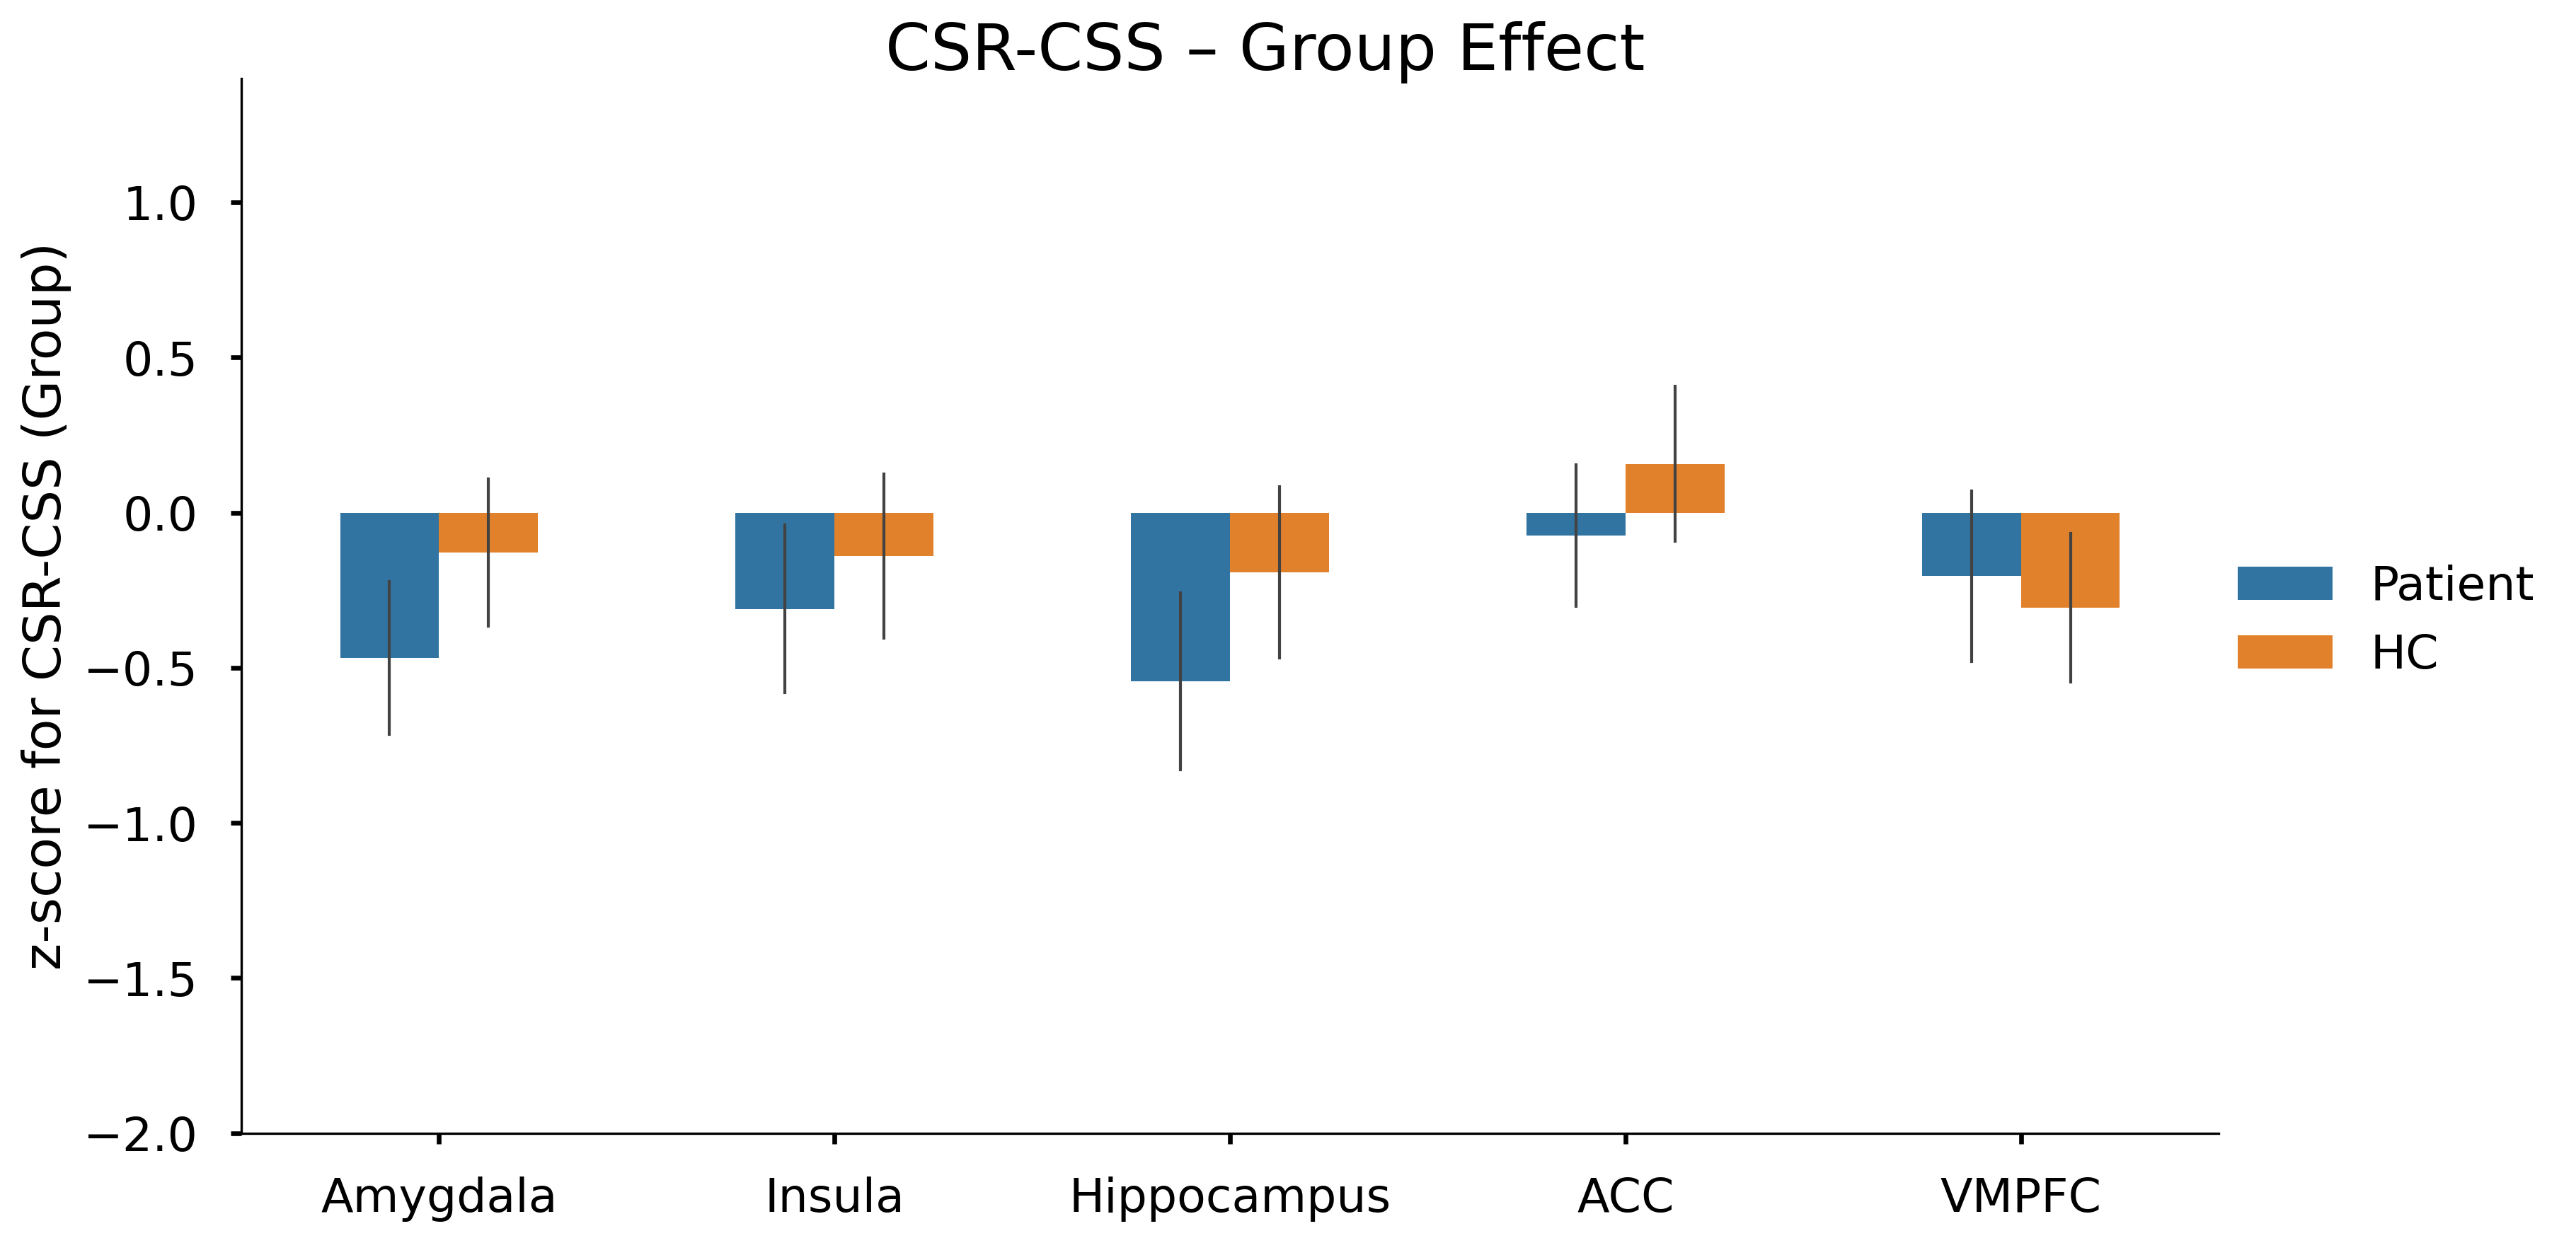


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.058     0.17    47    0.865      
Insula          Group[T.HC]                                             0.328     0.89    47    0.380      
Hippocampus     Group[T.HC]                                             0.216     0.49    47    0.624      
ACC             Group[T.HC]                                             0.571     1.59    47    0.119      
VMPFC           Group[T.HC]                                             0.012     0.03    47    0.975      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

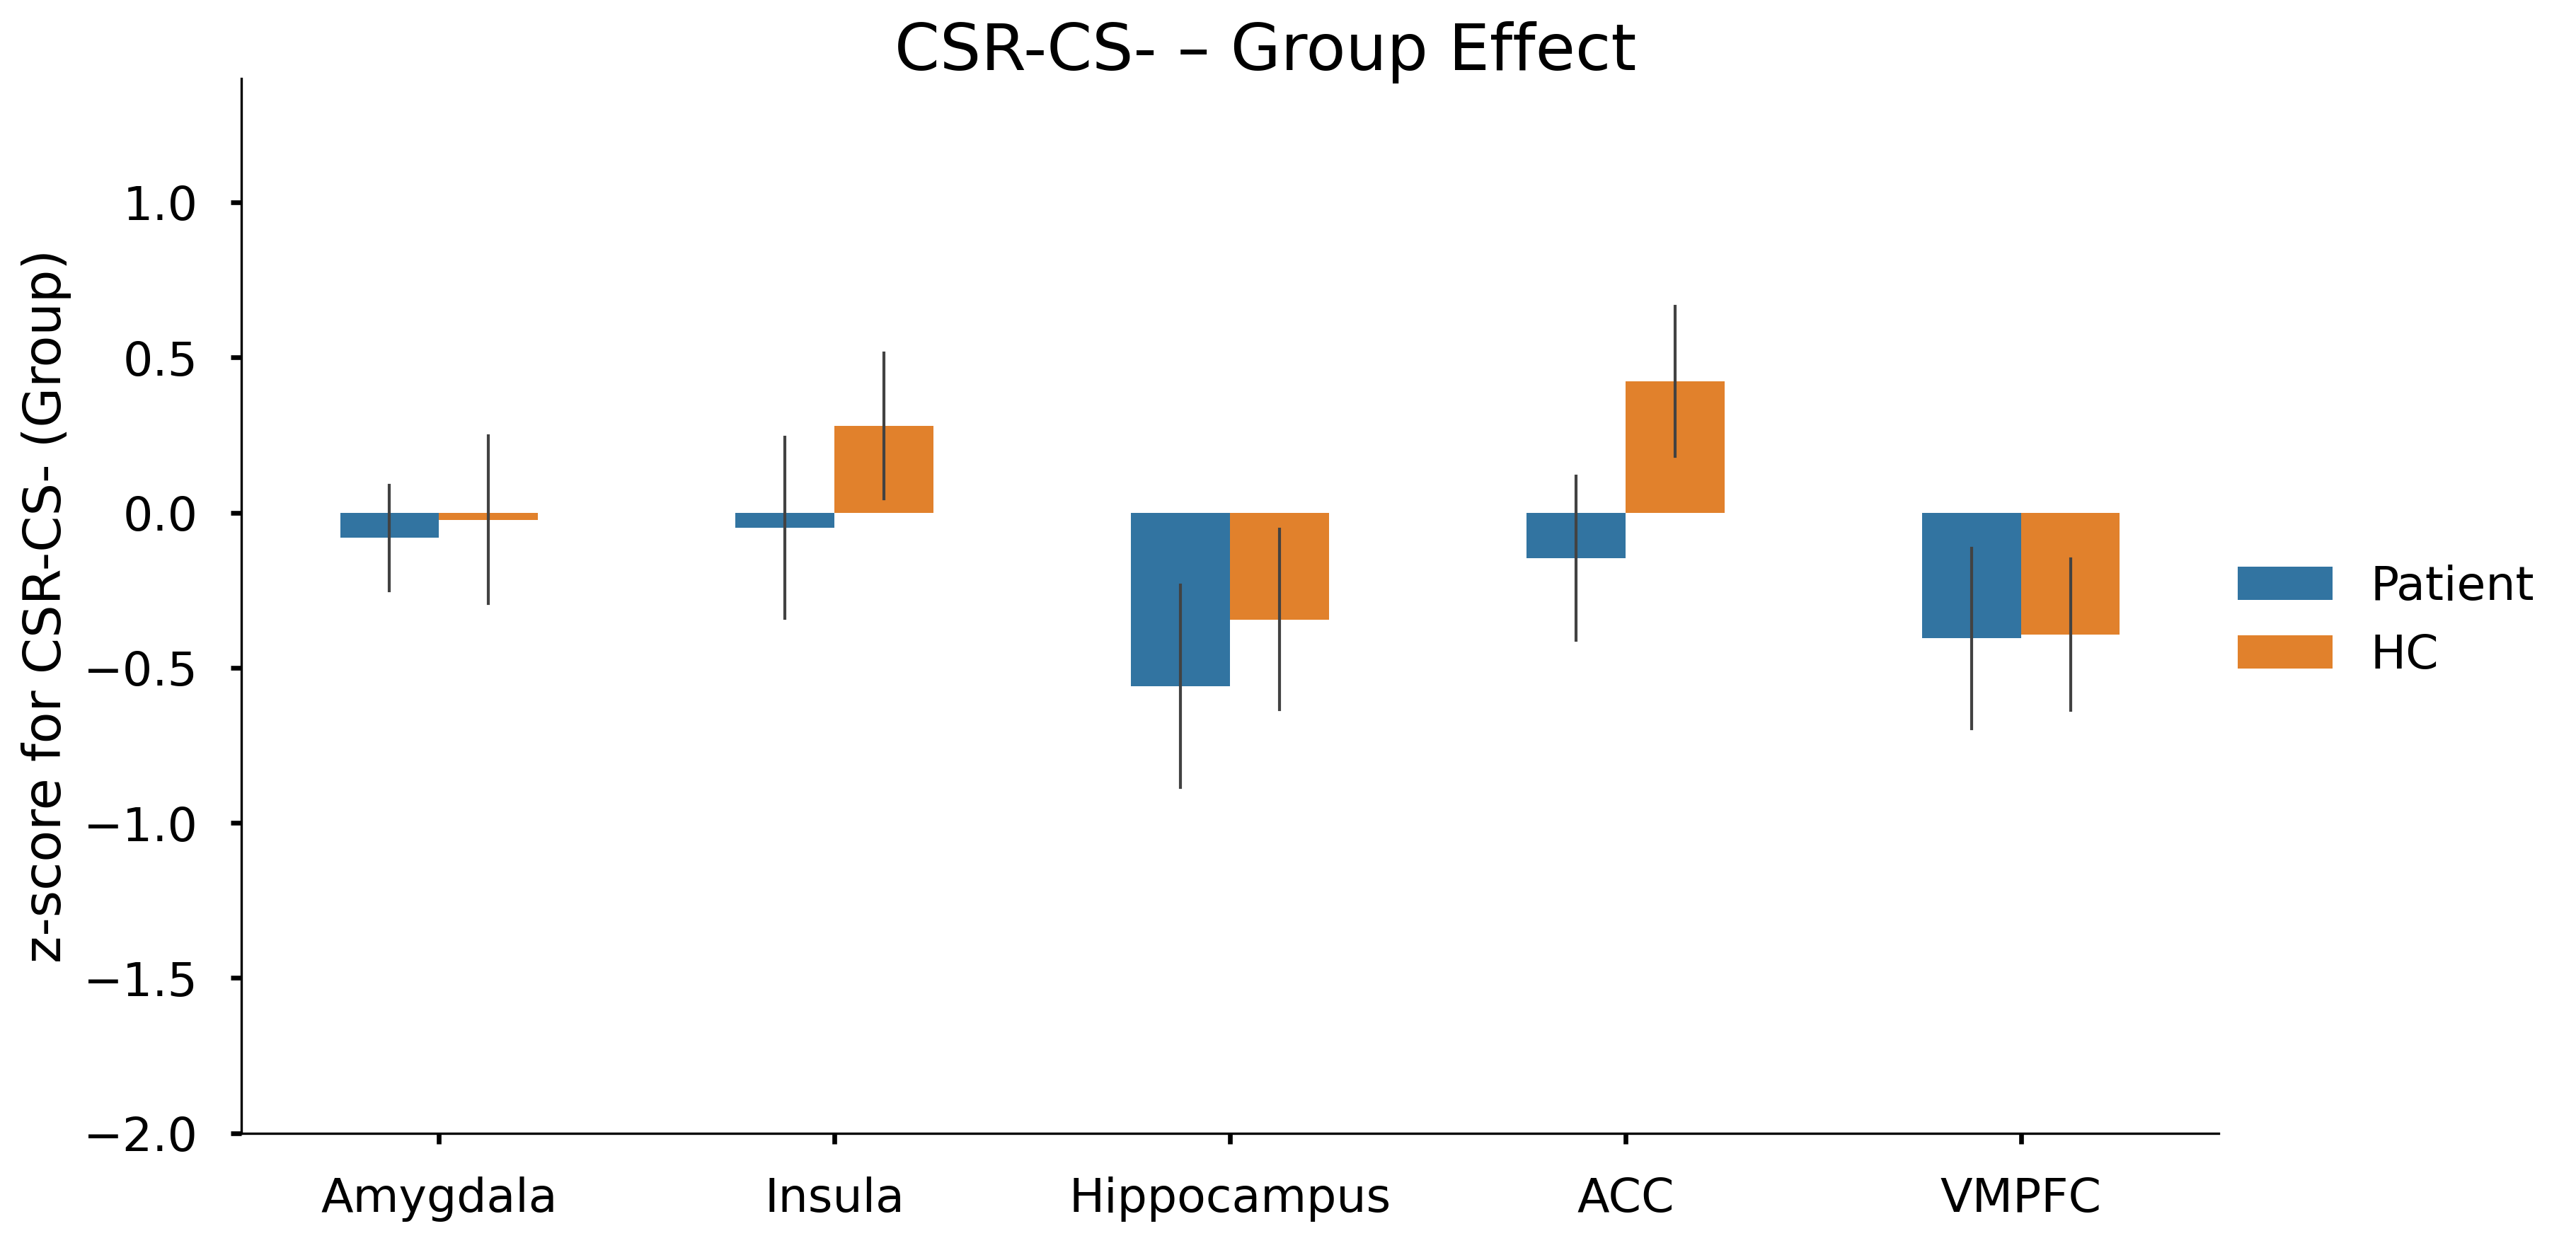


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.303    -0.86    47    0.393      
Insula          Group[T.HC]                                             0.130     0.31    47    0.755      
Hippocampus     Group[T.HC]                                            -0.173    -0.44    47    0.665      
ACC             Group[T.HC]                                             0.317     0.86    47    0.396      
VMPFC           Group[T.HC]                                             0.122     0.29    47    0.775      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

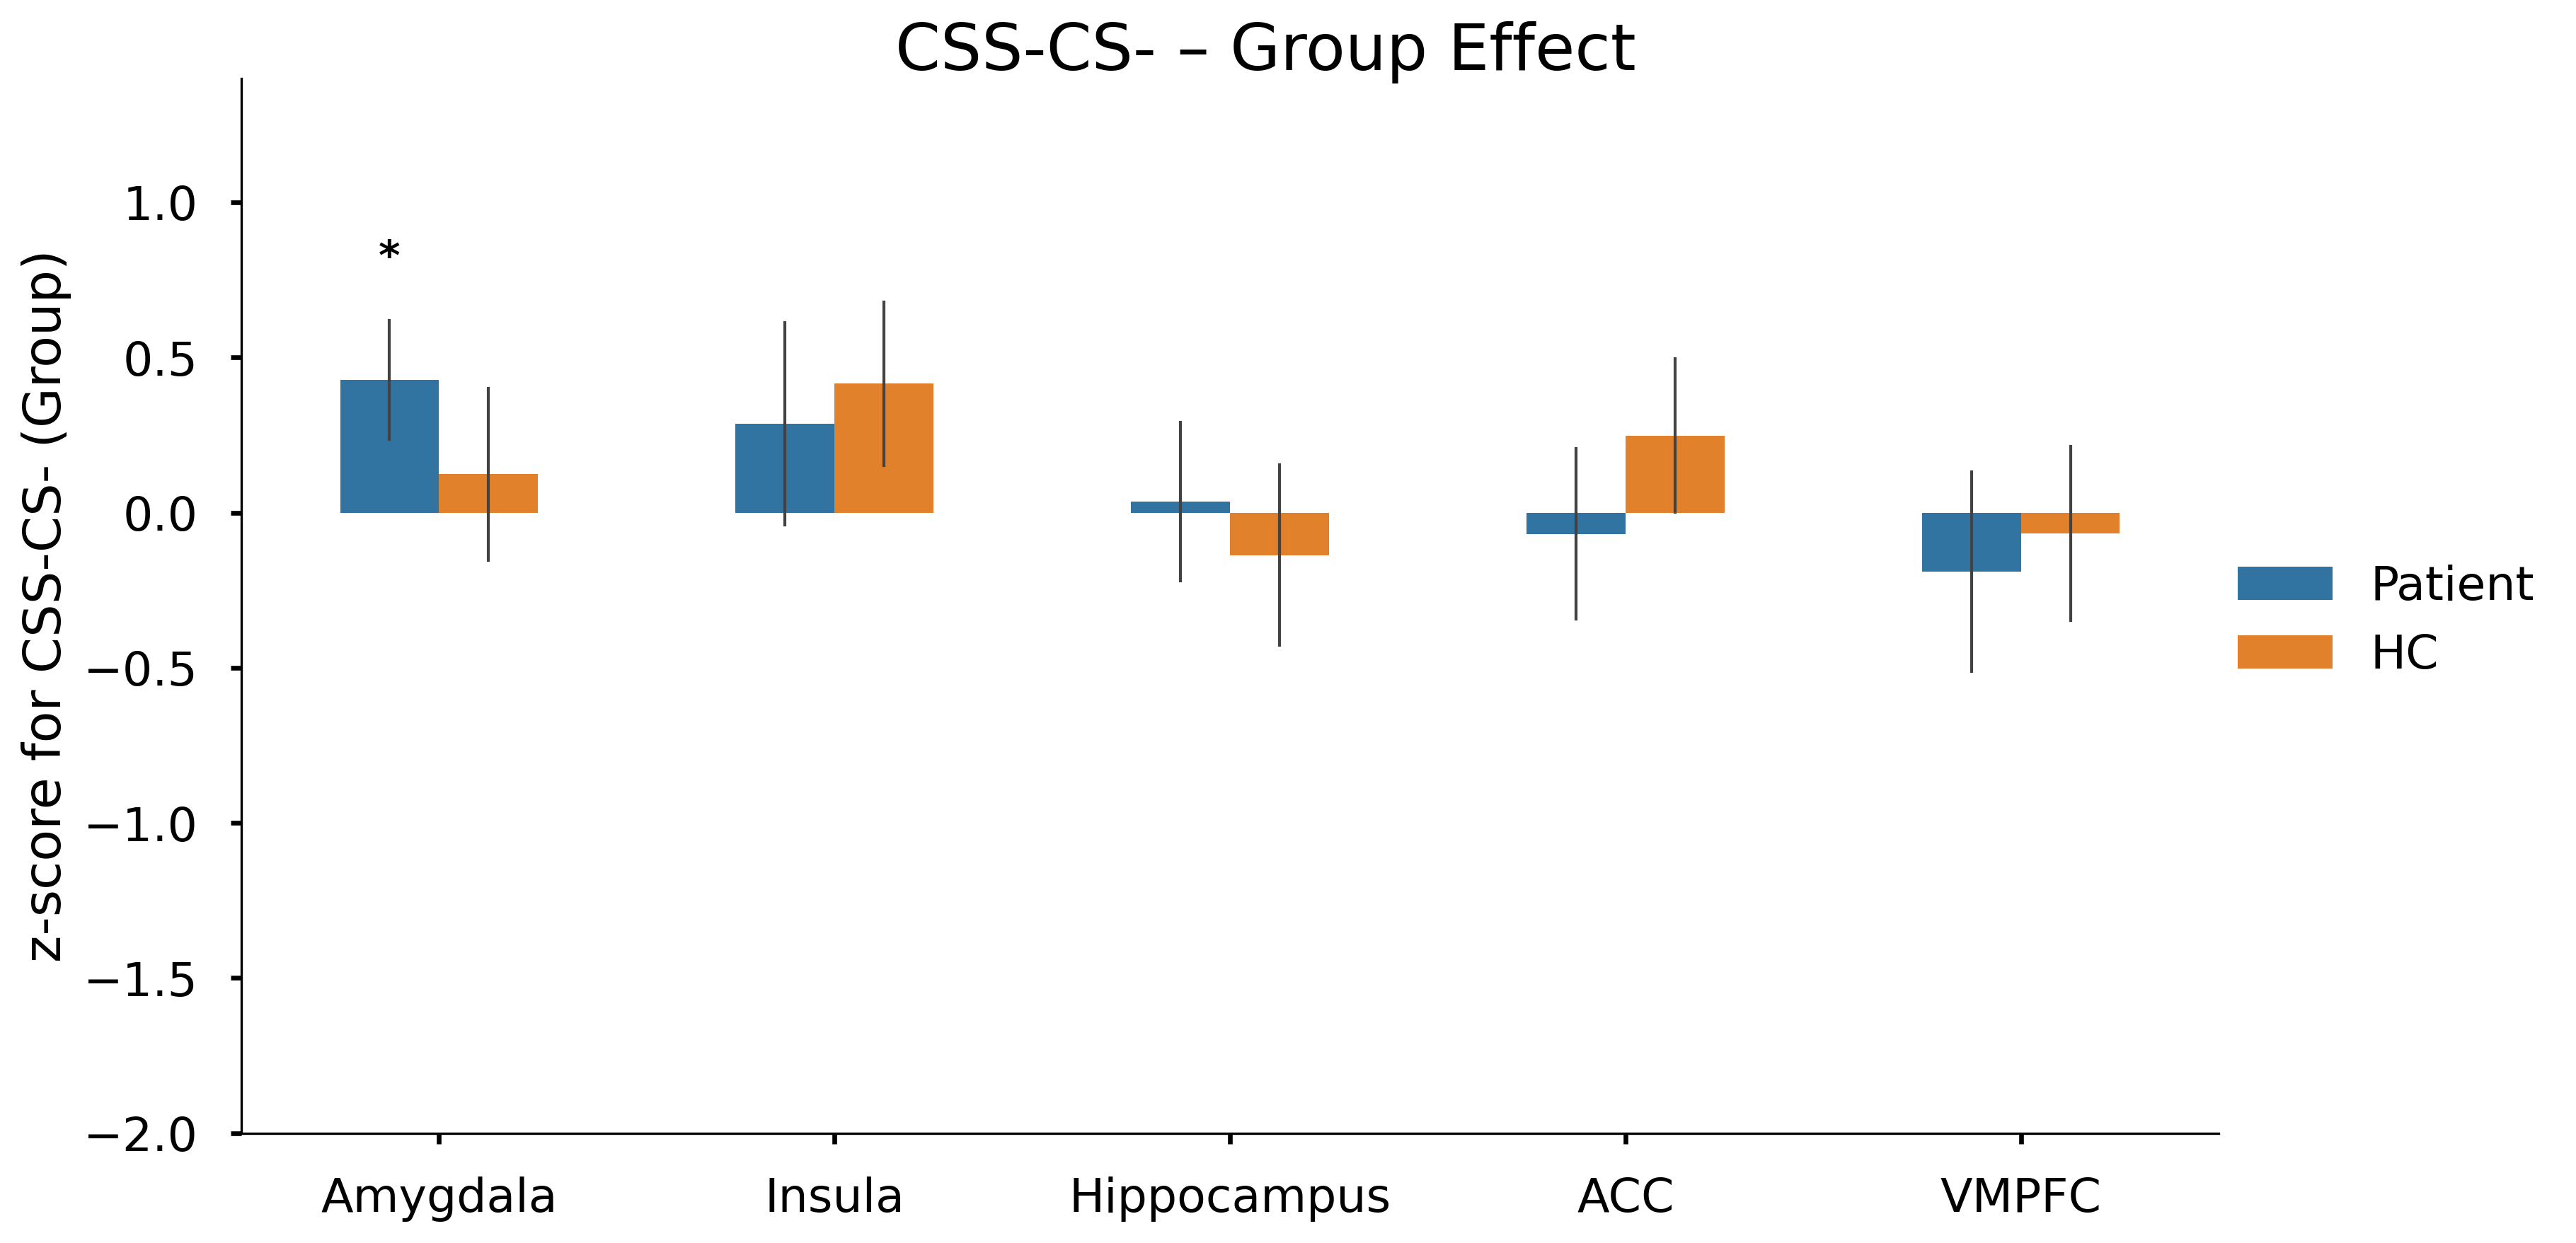


===== Group main effect: CSR-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.101     0.28    47    0.782      
Insula          Group[T.HC]                                             0.341     0.96    47    0.342      
Hippocampus     Group[T.HC]                                             0.133     0.29    47    0.771      
ACC             Group[T.HC]                                             0.655     1.53    47    0.134      
VMPFC           Group[T.HC]                                             0.319     0.83    47    0.409      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

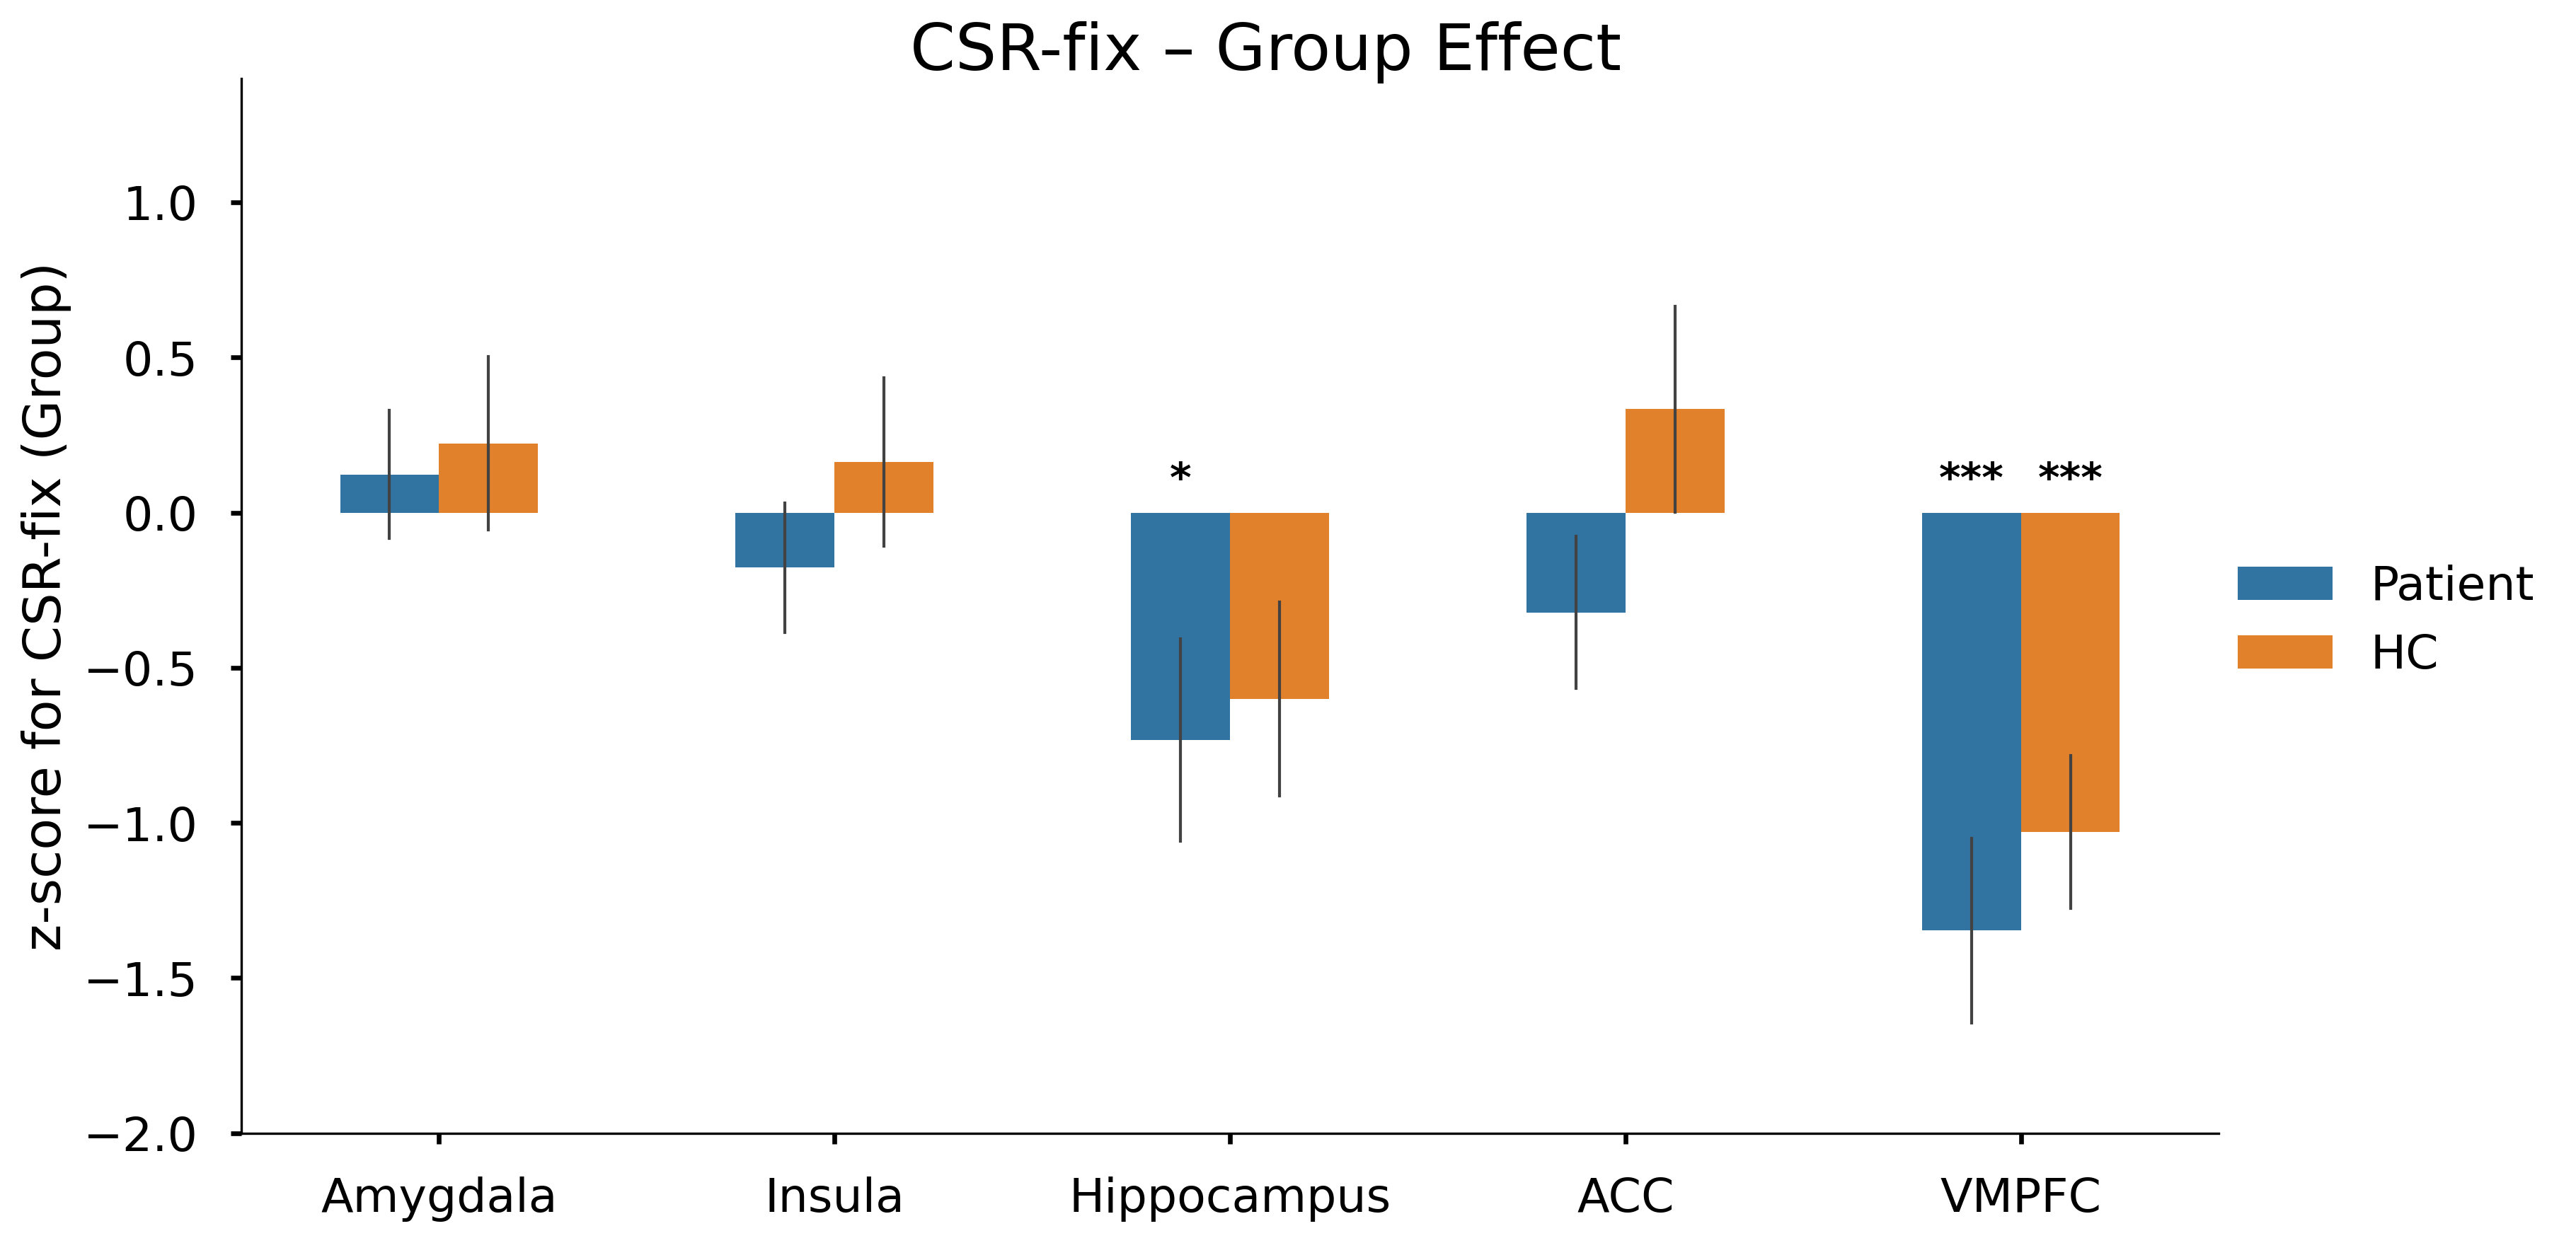


===== Group main effect: CSS-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.351    -1.22    47    0.228      
Insula          Group[T.HC]                                             0.107     0.30    47    0.769      
Hippocampus     Group[T.HC]                                            -0.329    -0.99    47    0.328      
ACC             Group[T.HC]                                             0.327     0.91    47    0.367      
VMPFC           Group[T.HC]                                             0.437     1.03    47    0.307      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

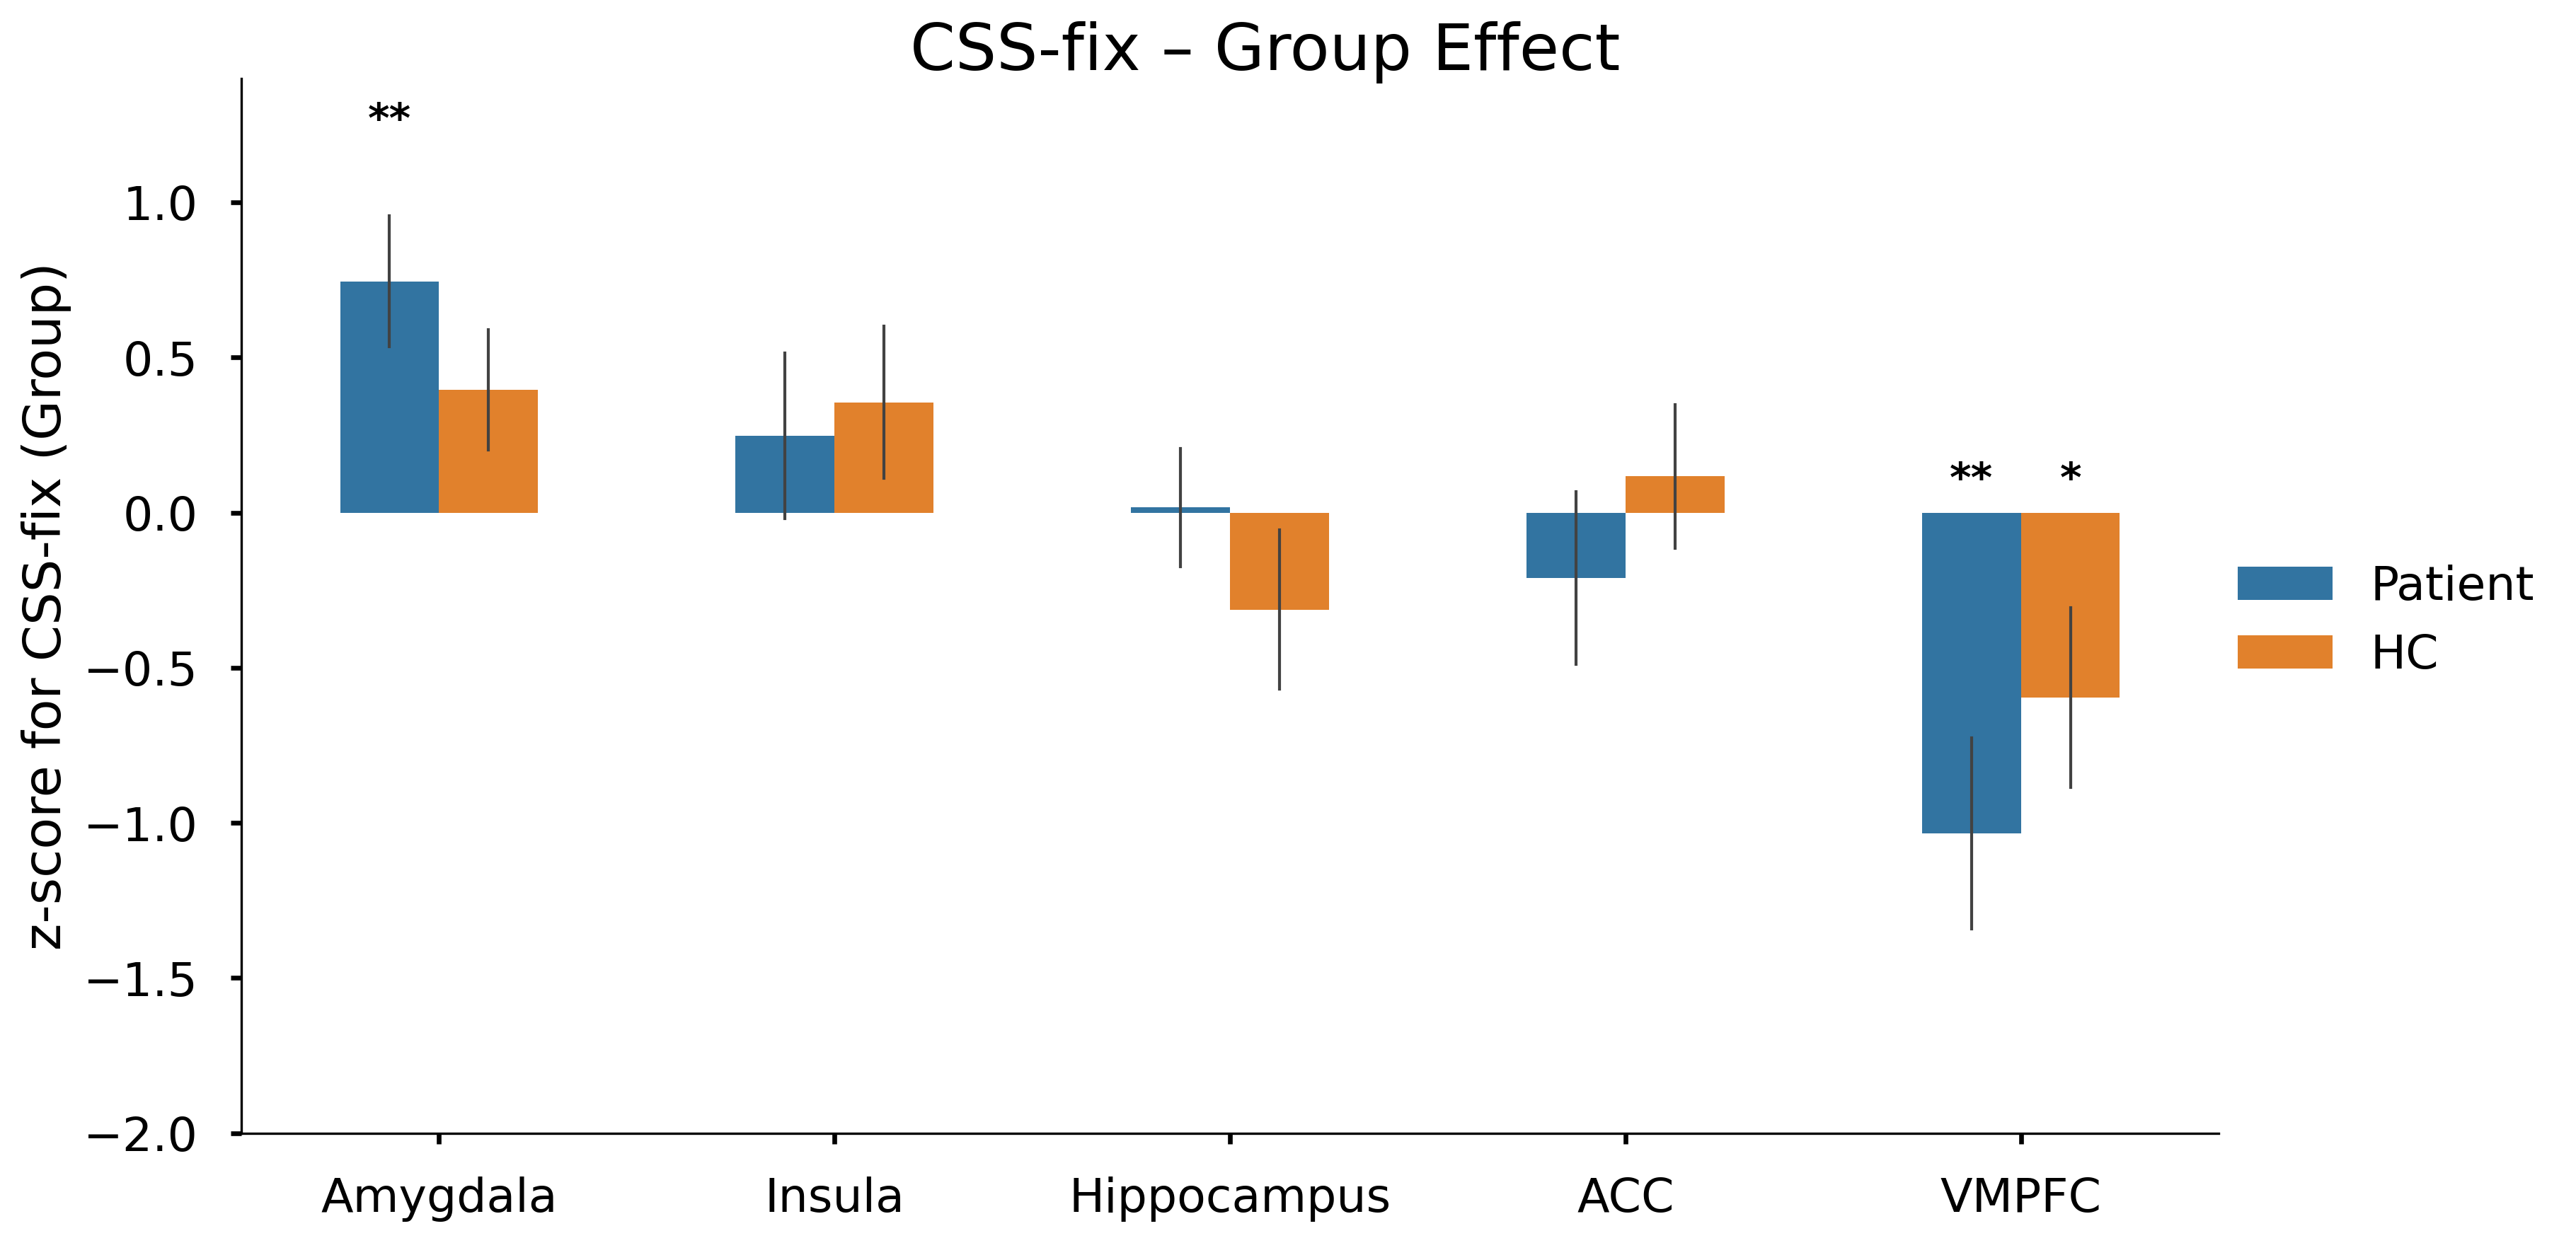


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.044     0.13    47    0.900      
Insula          Group[T.HC]                                            -0.076    -0.19    47    0.852      
Hippocampus     Group[T.HC]                                            -0.136    -0.38    47    0.702      
ACC             Group[T.HC]                                            -0.083    -0.22    47    0.830      
VMPFC           Group[T.HC]                                             0.314     0.86    47    0.395      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                  

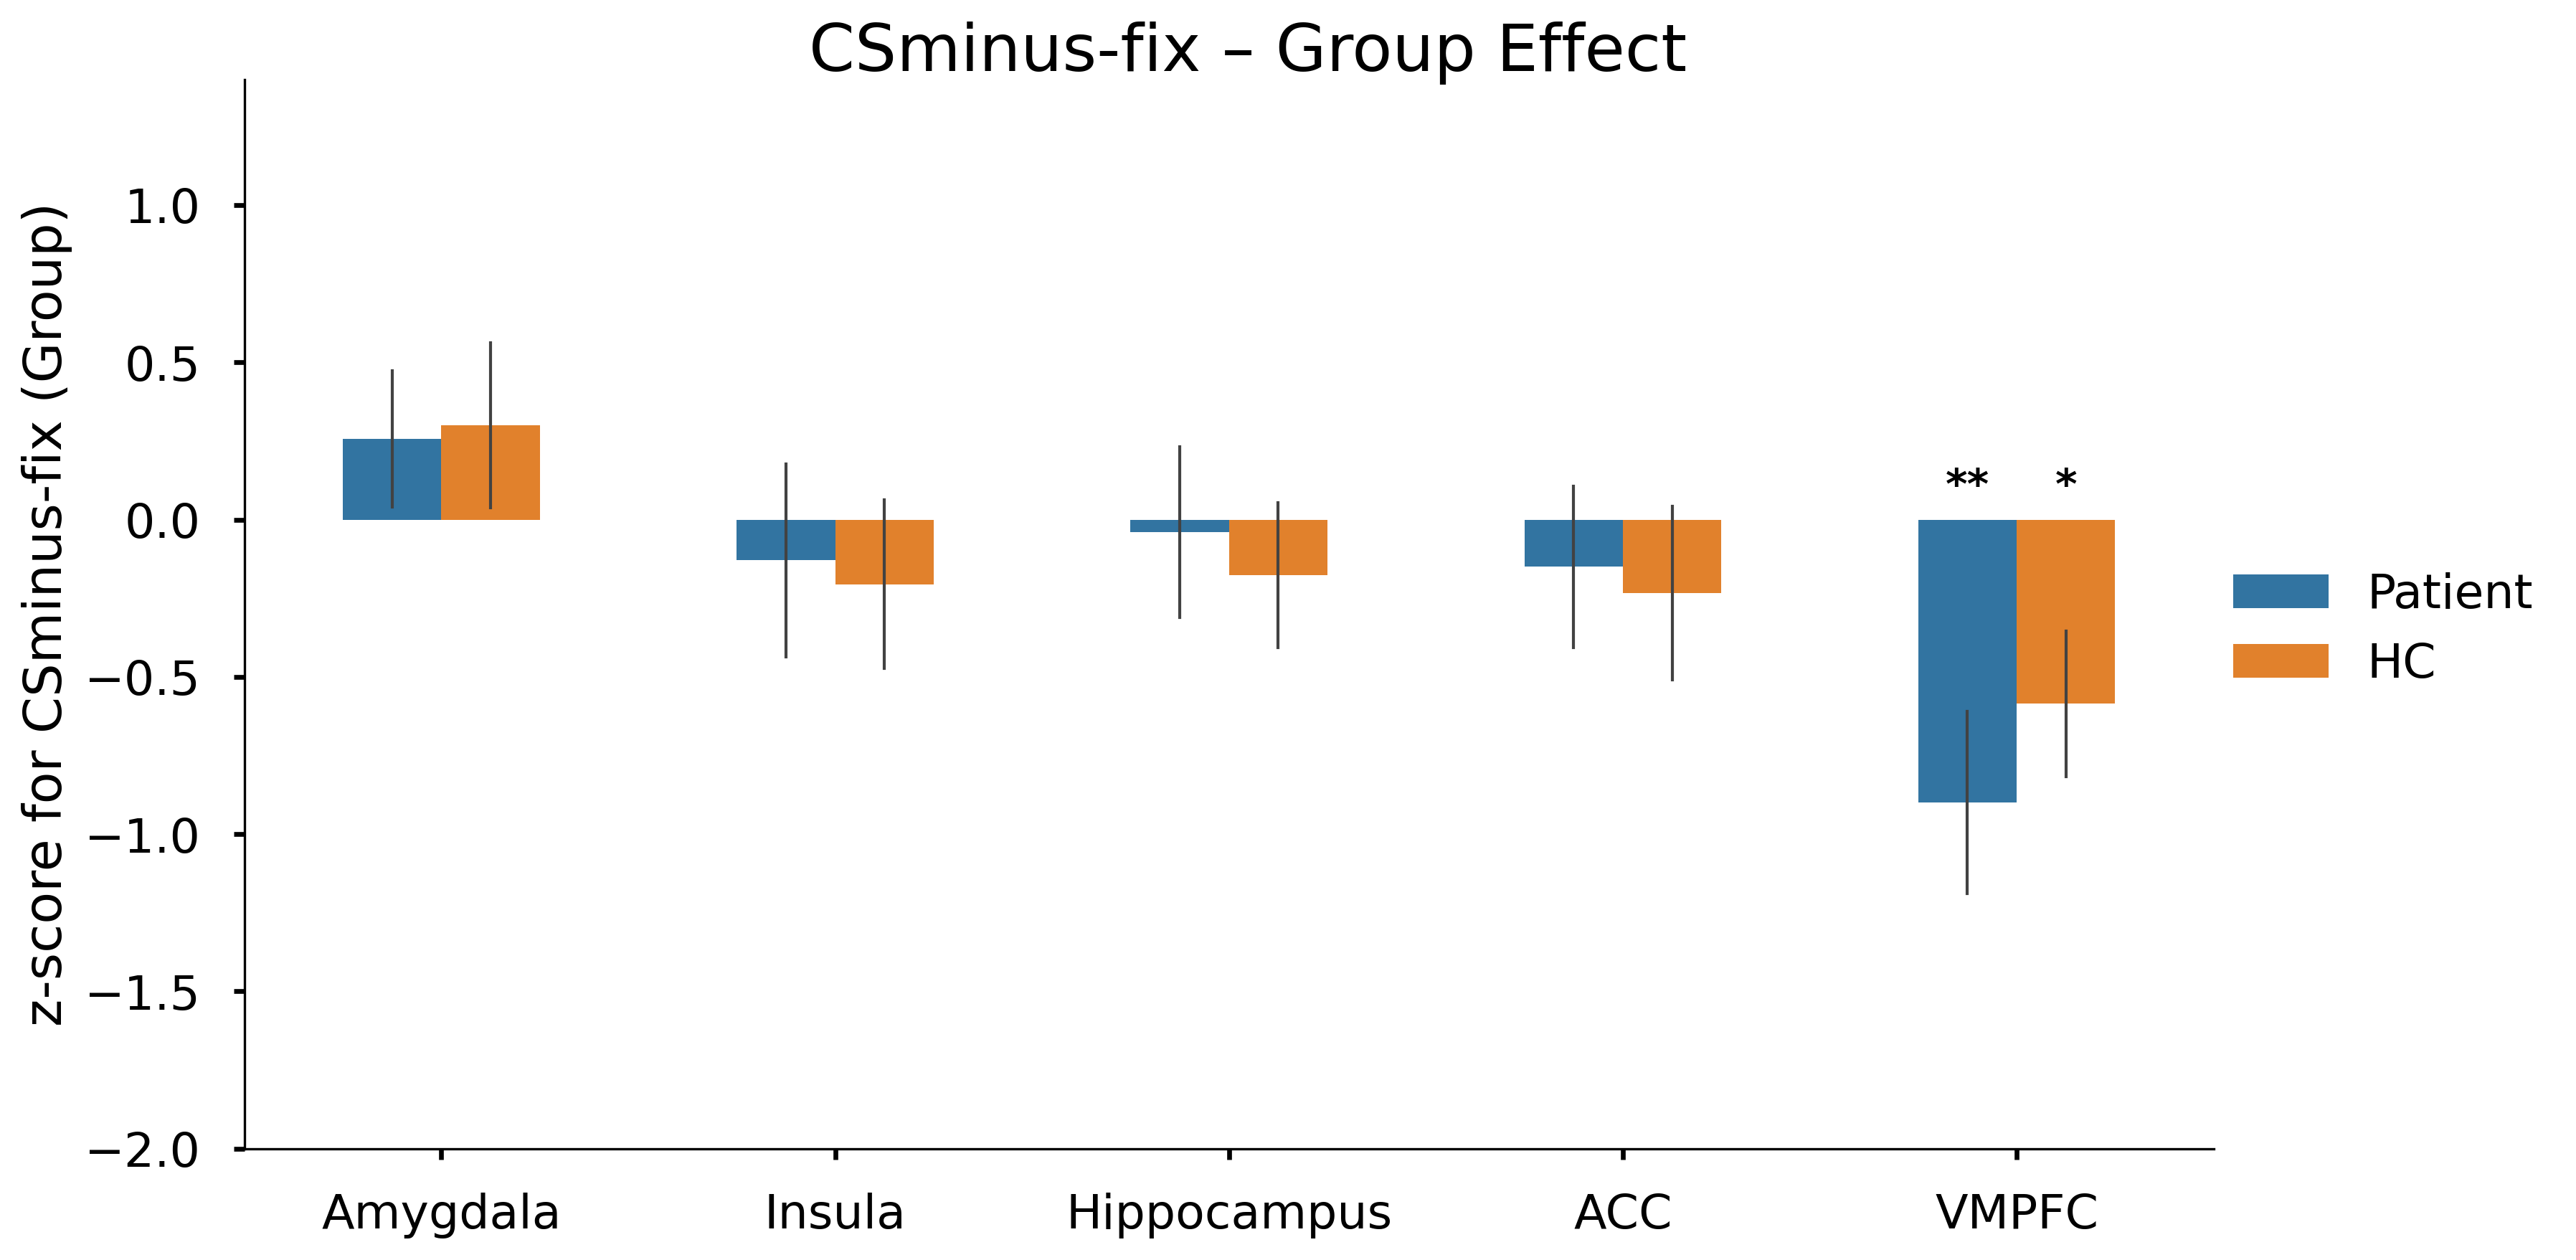

In [10]:
# 1️⃣ Group main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Group',
        order=ROI_list, hue_order=group_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Group")[0], hue_order=group_list)


    g.set_axis_labels('', f'z-score for {contrast} (Group)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Group Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Group_sig.png', bbox_inches='tight')
    plt.show()


===== Gender main effect: CSR-CSS =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.338     1.45    98    0.150      
Insula          Gender[T.Female]                                       -0.359    -1.43    98    0.157      
Hippocampus     Gender[T.Female]                                        0.213     0.83    98    0.406      
ACC             Gender[T.Female]                                       -0.185    -0.73    98    0.466      
VMPFC           Gender[T.Female]                                        0.131     0.48    98    0.632      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

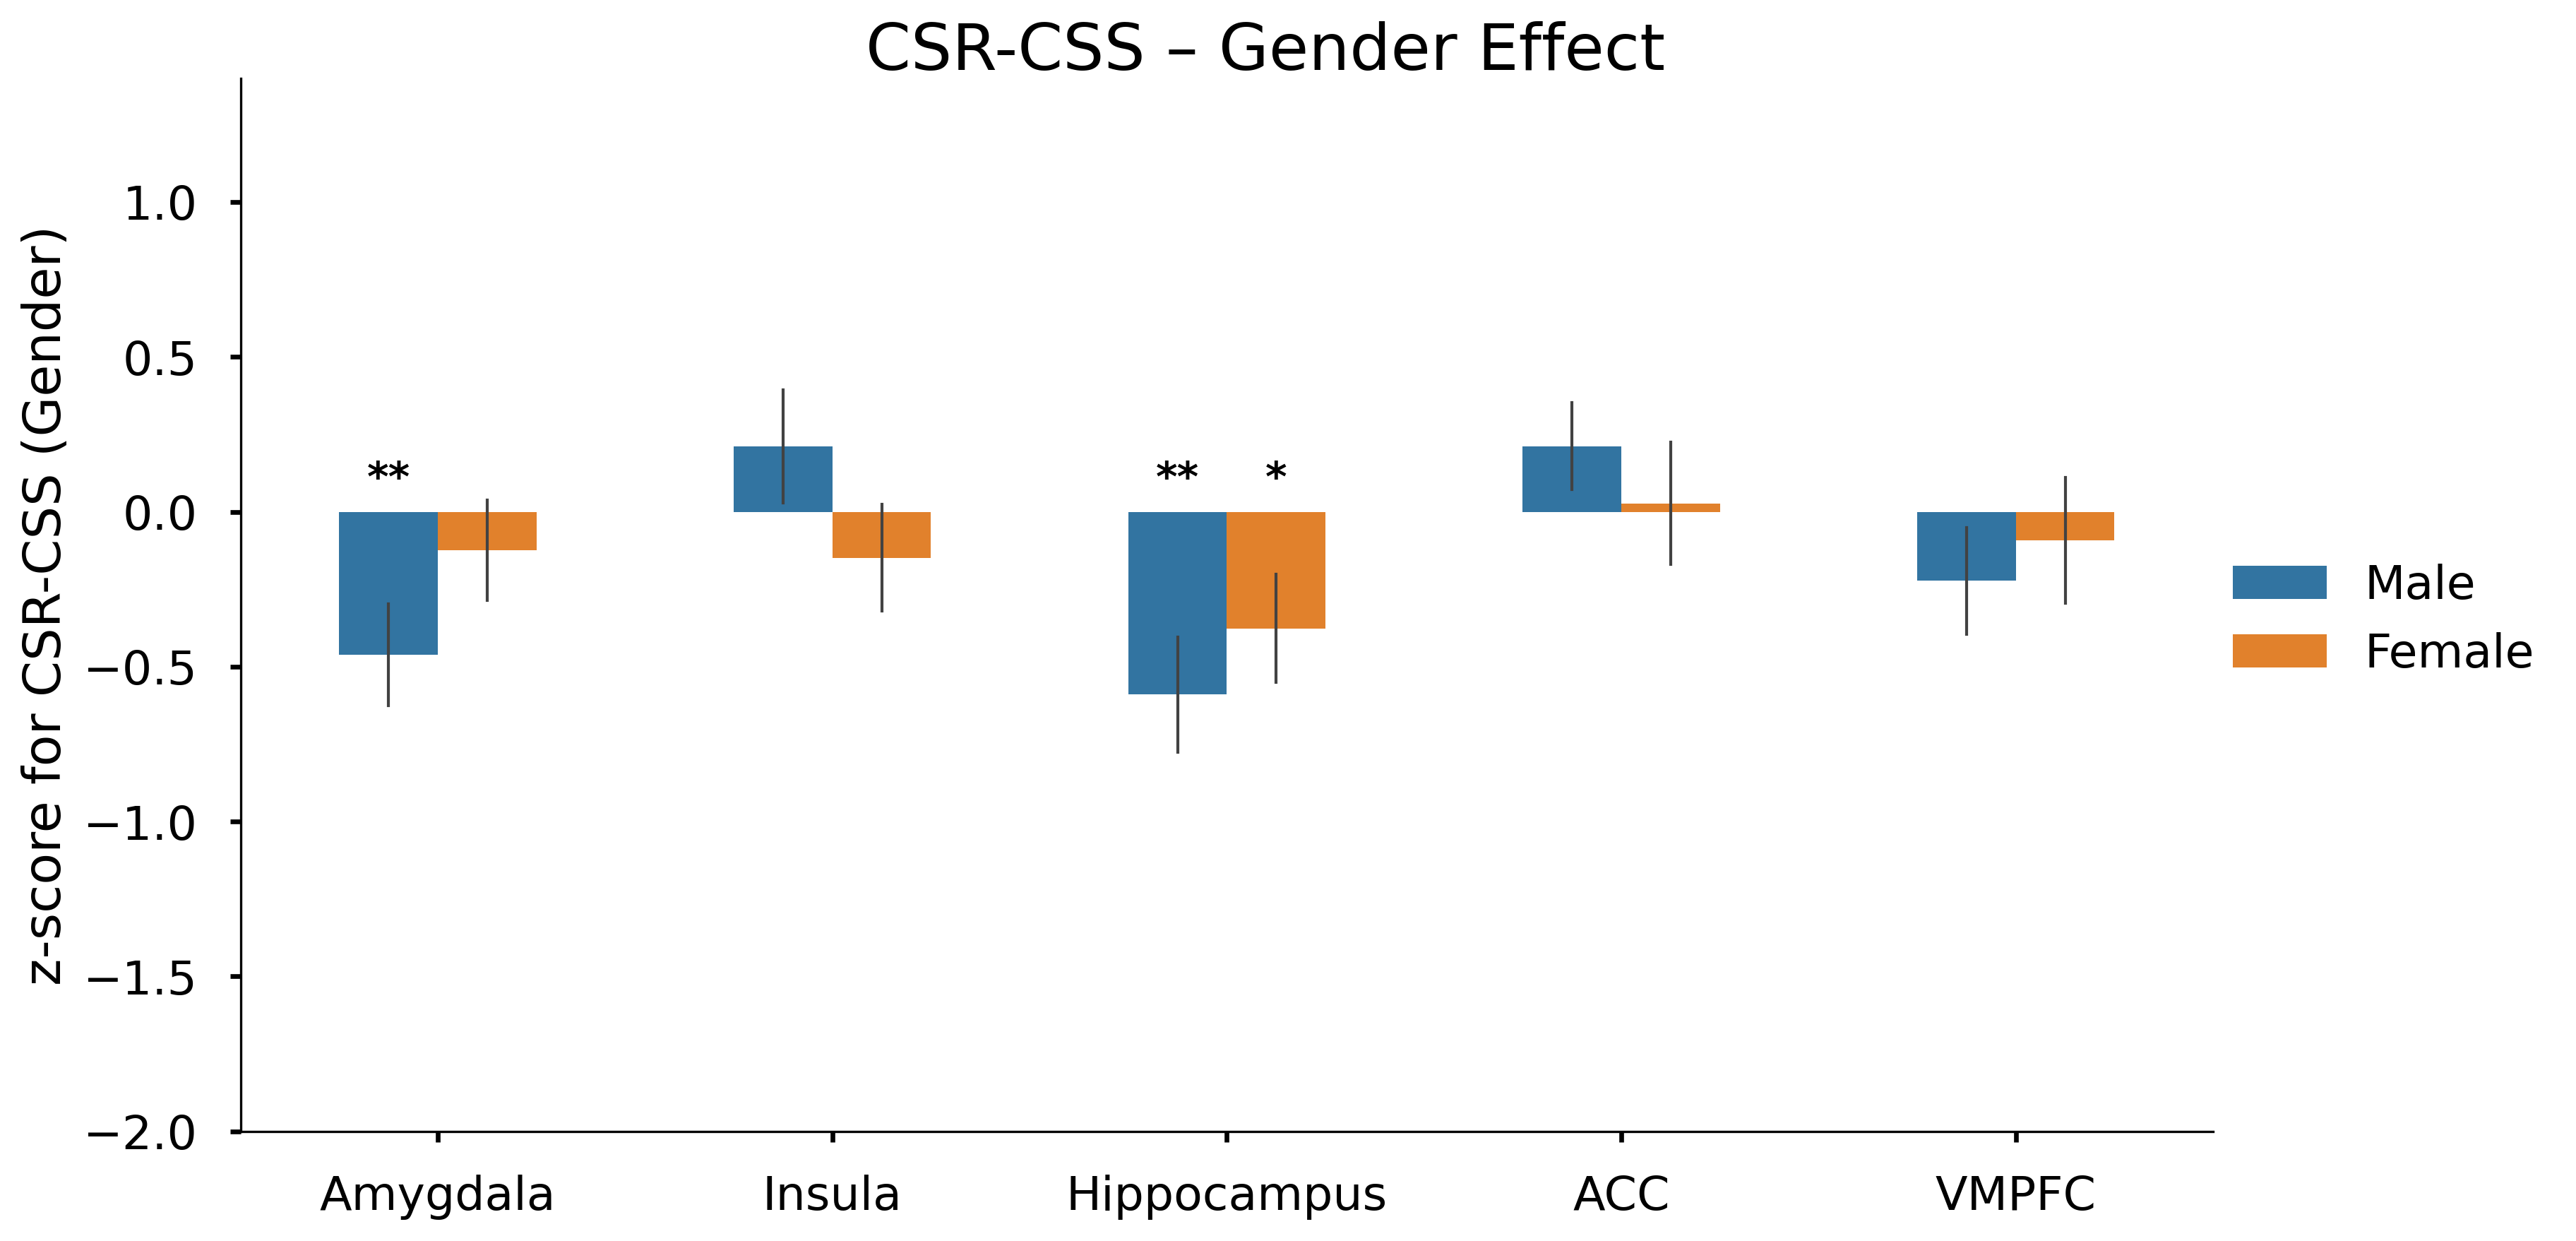


===== Gender main effect: CSR-CS- =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.378     1.64    98    0.105      
Insula          Gender[T.Female]                                        0.014     0.05    98    0.961      
Hippocampus     Gender[T.Female]                                        0.157     0.53    98    0.595      
ACC             Gender[T.Female]                                       -0.238    -0.83    98    0.406      
VMPFC           Gender[T.Female]                                       -0.047    -0.16    98    0.873      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

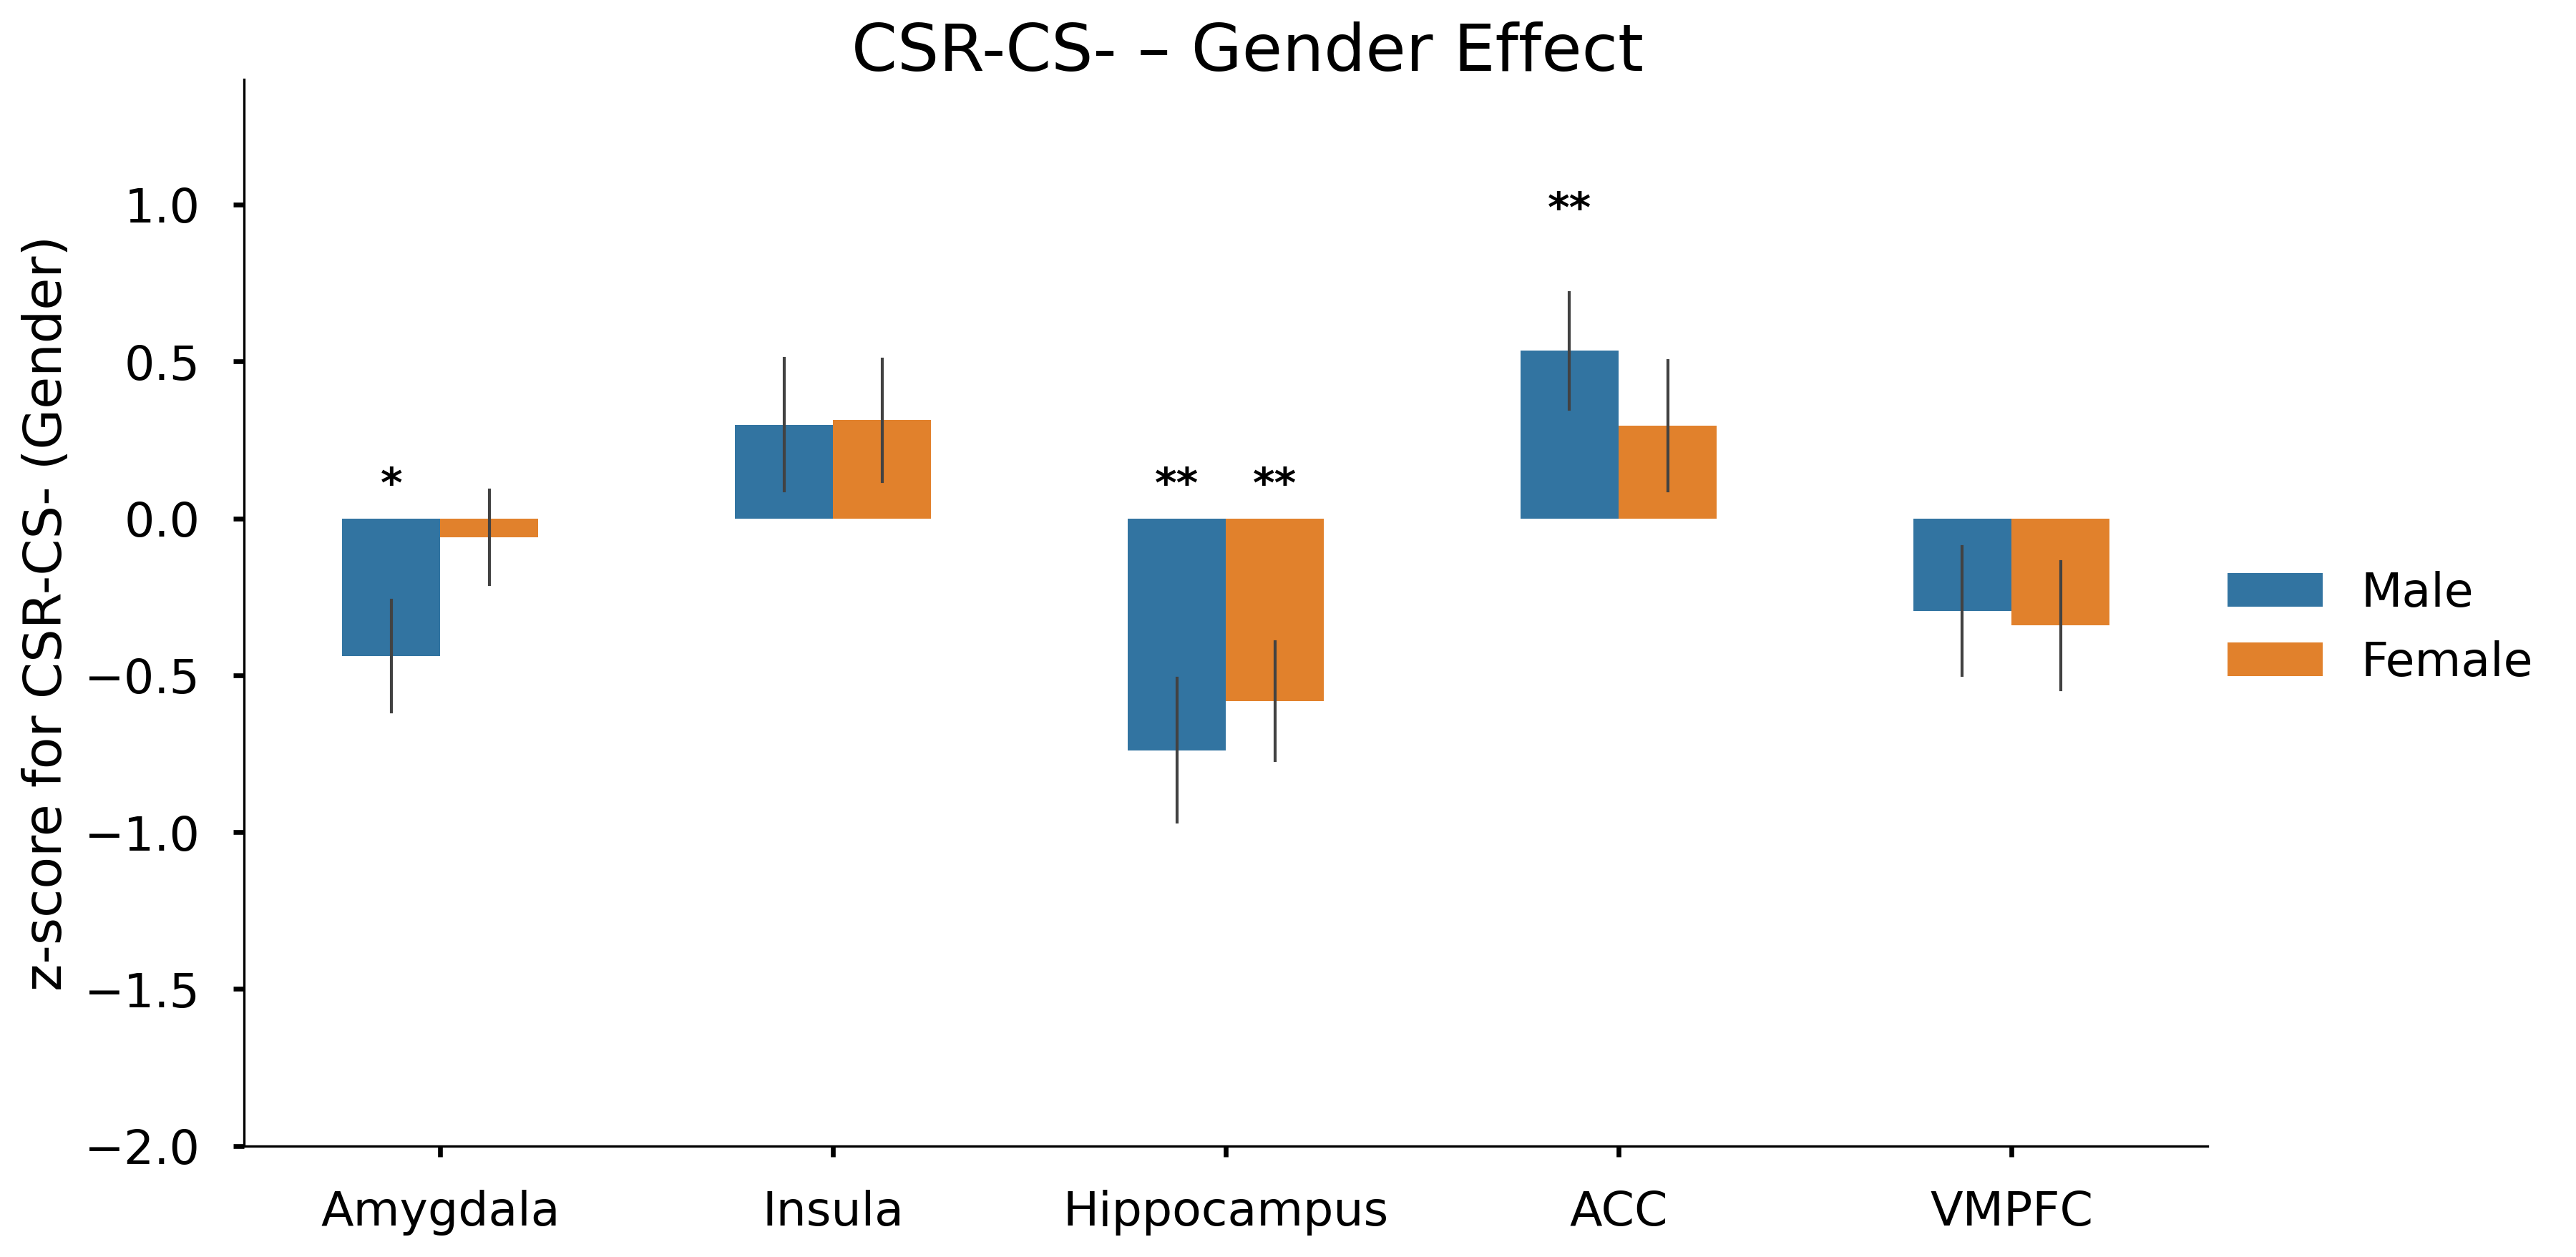


===== Gender main effect: CSS-CS- =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.008    -0.03    98    0.973      
Insula          Gender[T.Female]                                        0.392     1.38    98    0.172      
Hippocampus     Gender[T.Female]                                       -0.094    -0.38    98    0.702      
ACC             Gender[T.Female]                                       -0.041    -0.15    98    0.880      
VMPFC           Gender[T.Female]                                       -0.196    -0.74    98    0.463      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

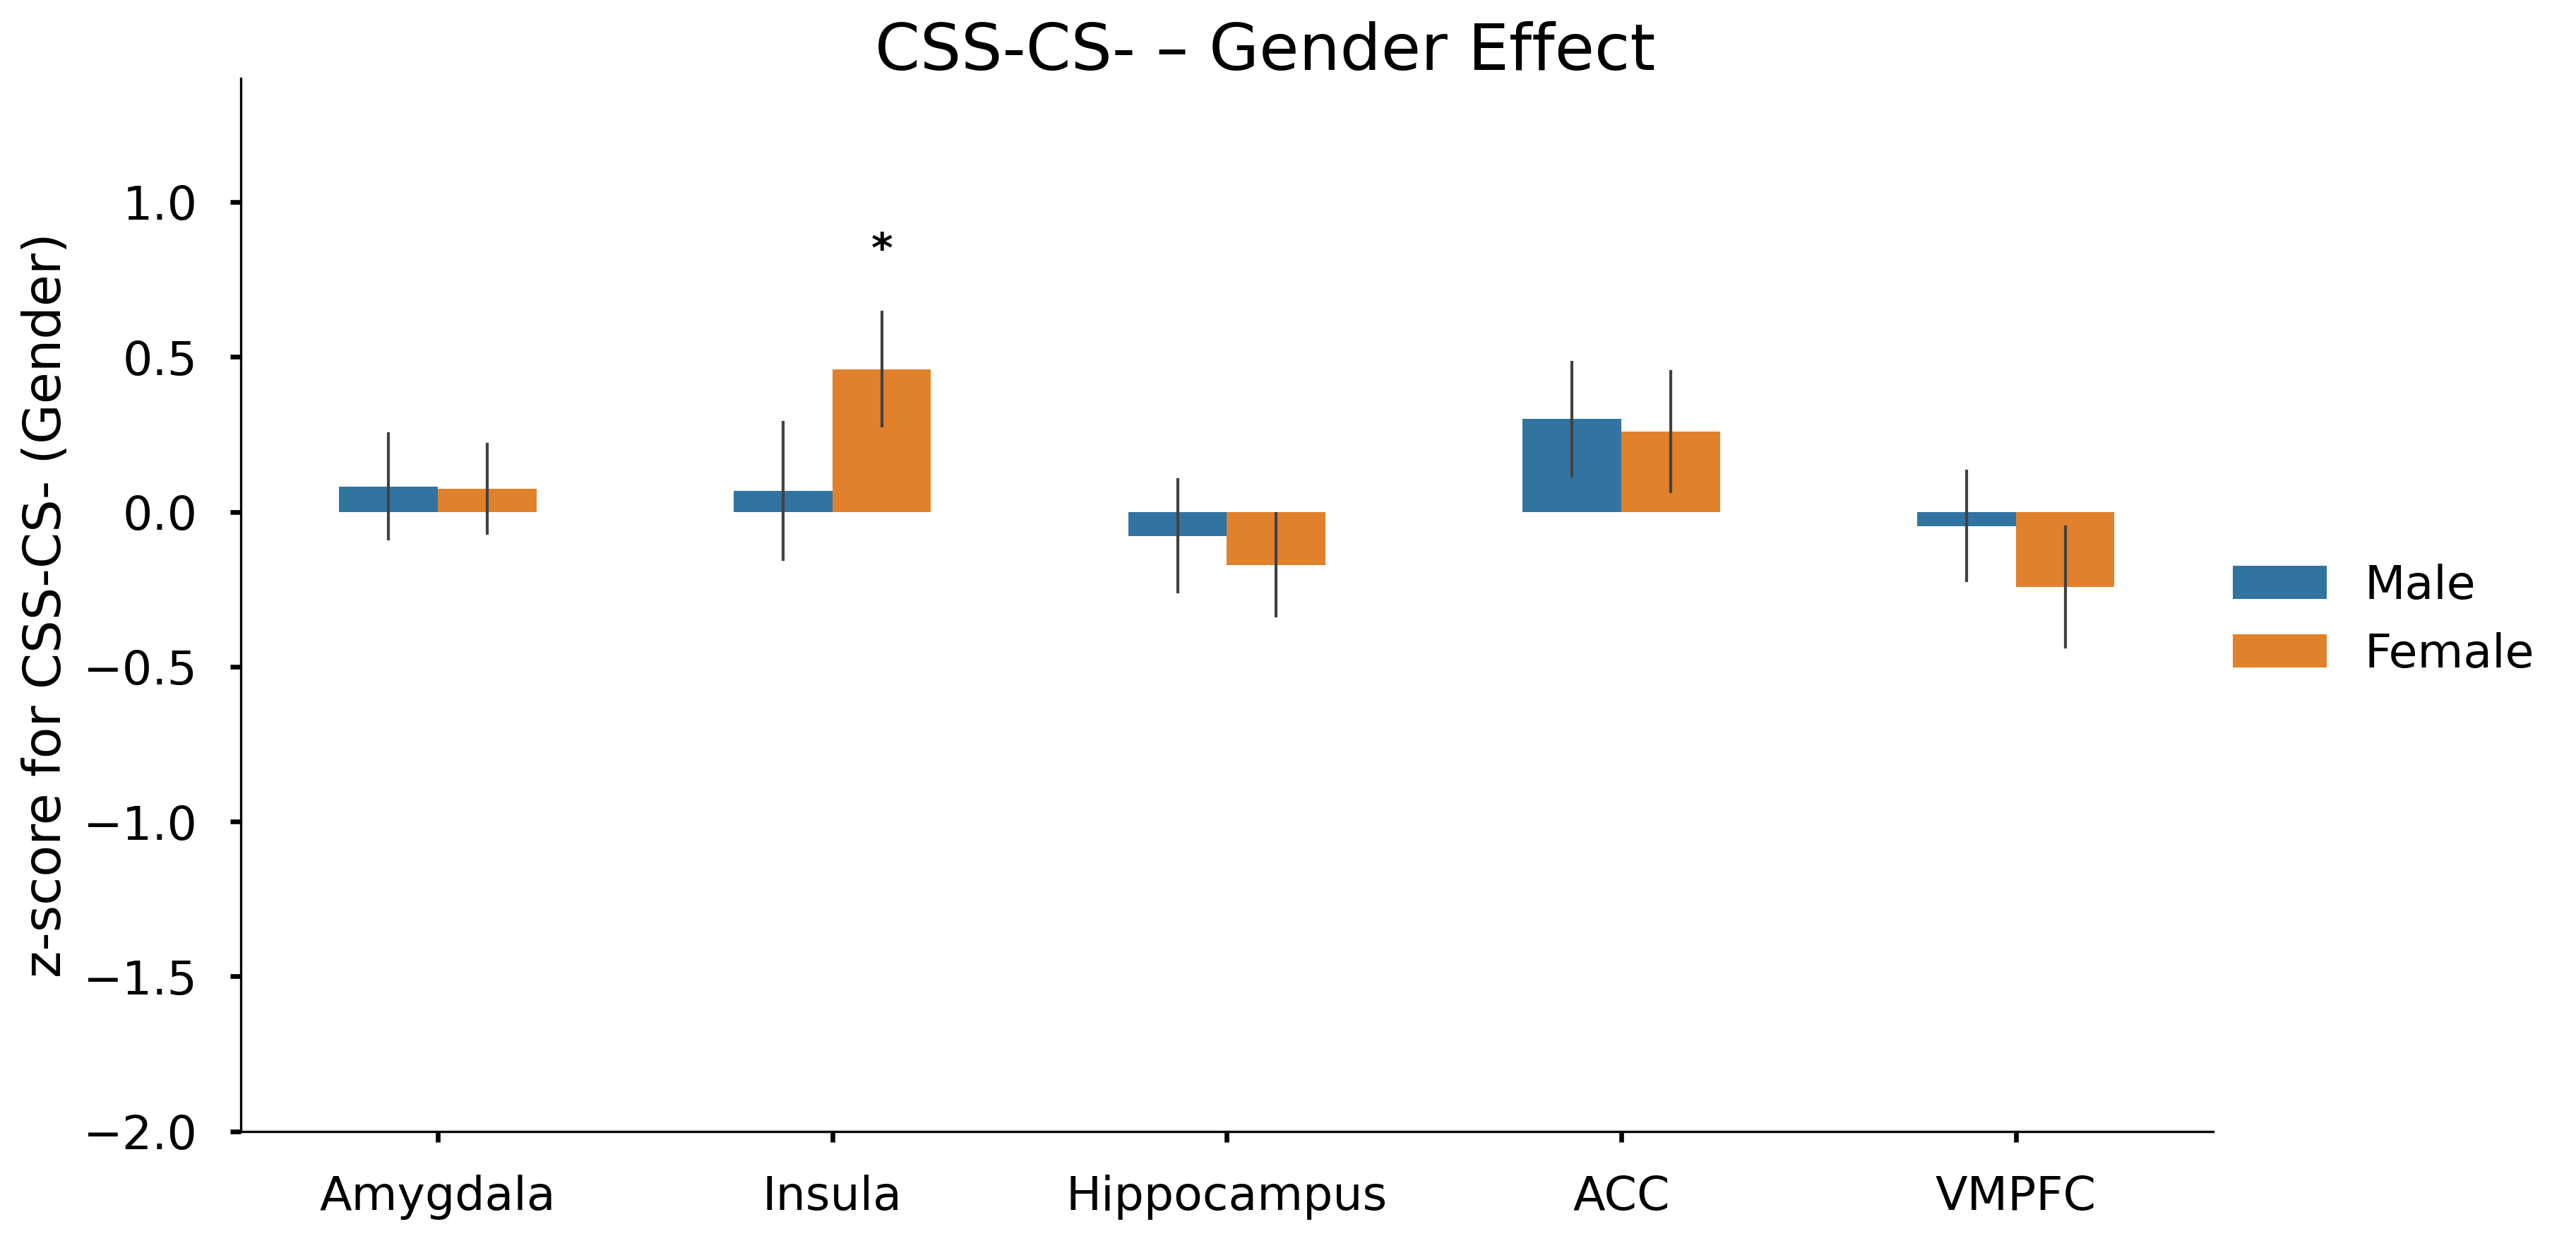


===== Gender main effect: CSR-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.591     2.35    98    0.021     *
Insula          Gender[T.Female]                                       -0.154    -0.63    98    0.527      
Hippocampus     Gender[T.Female]                                        0.494     1.69    98    0.093      
ACC             Gender[T.Female]                                       -0.565    -1.99    98    0.049     *
VMPFC           Gender[T.Female]                                        0.132     0.46    98    0.649      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

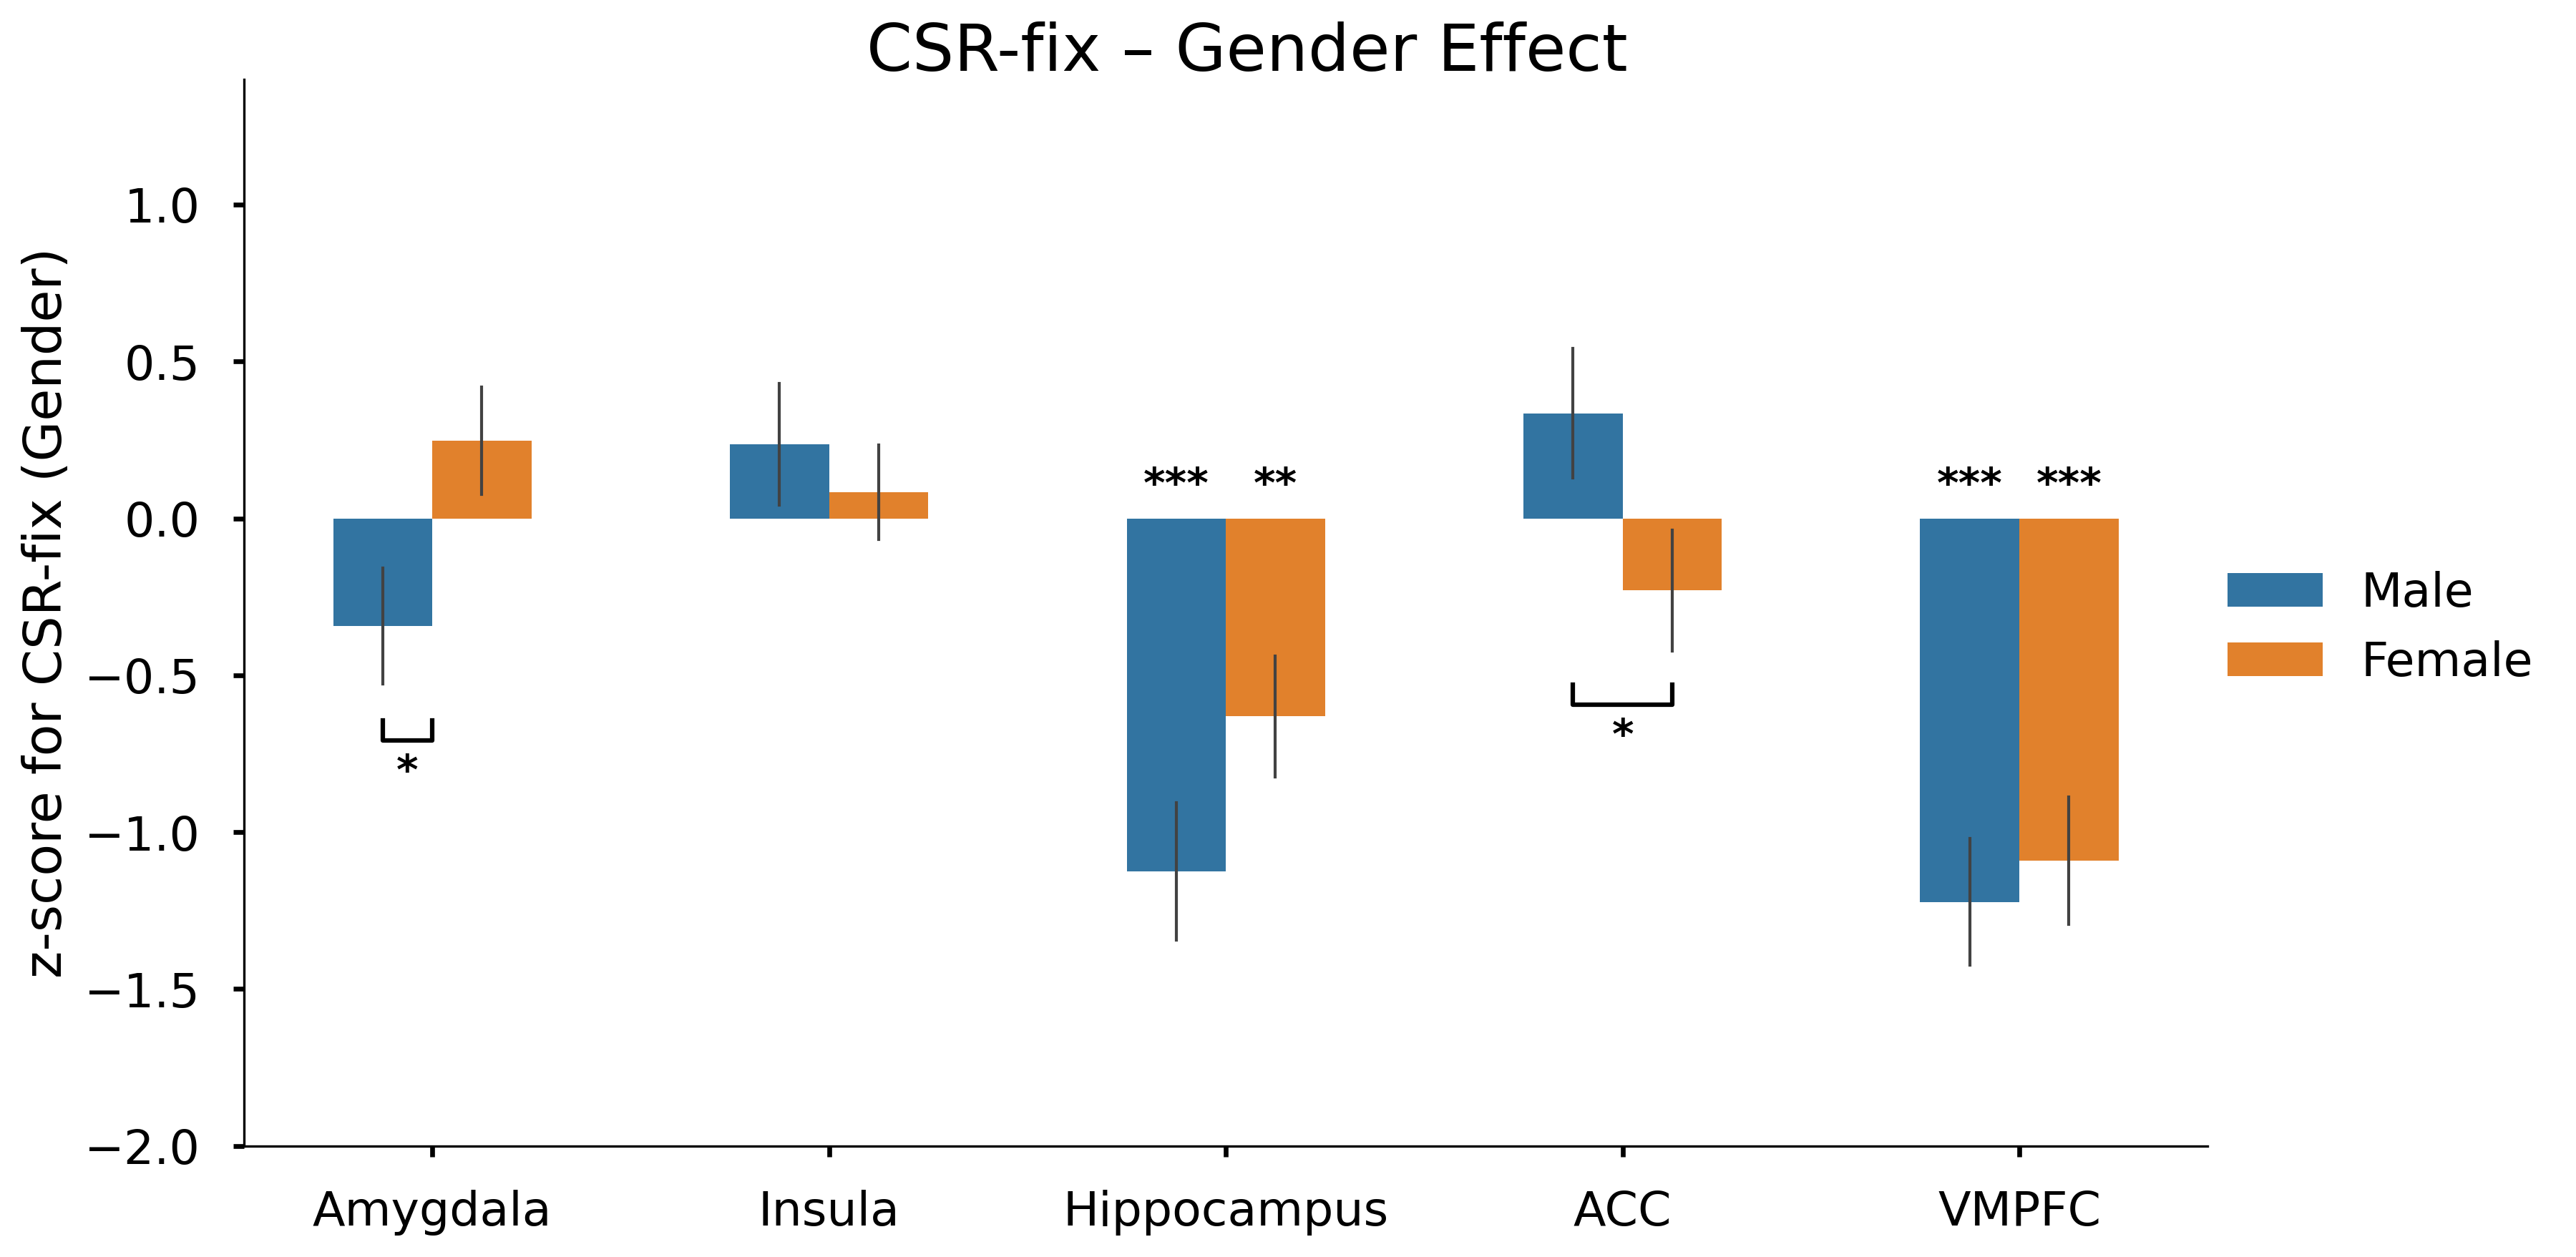


===== Gender main effect: CSS-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.115     0.50    98    0.615      
Insula          Gender[T.Female]                                        0.331     1.31    98    0.194      
Hippocampus     Gender[T.Female]                                        0.186     0.78    98    0.437      
ACC             Gender[T.Female]                                       -0.308    -1.19    98    0.235      
VMPFC           Gender[T.Female]                                       -0.065    -0.23    98    0.821      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

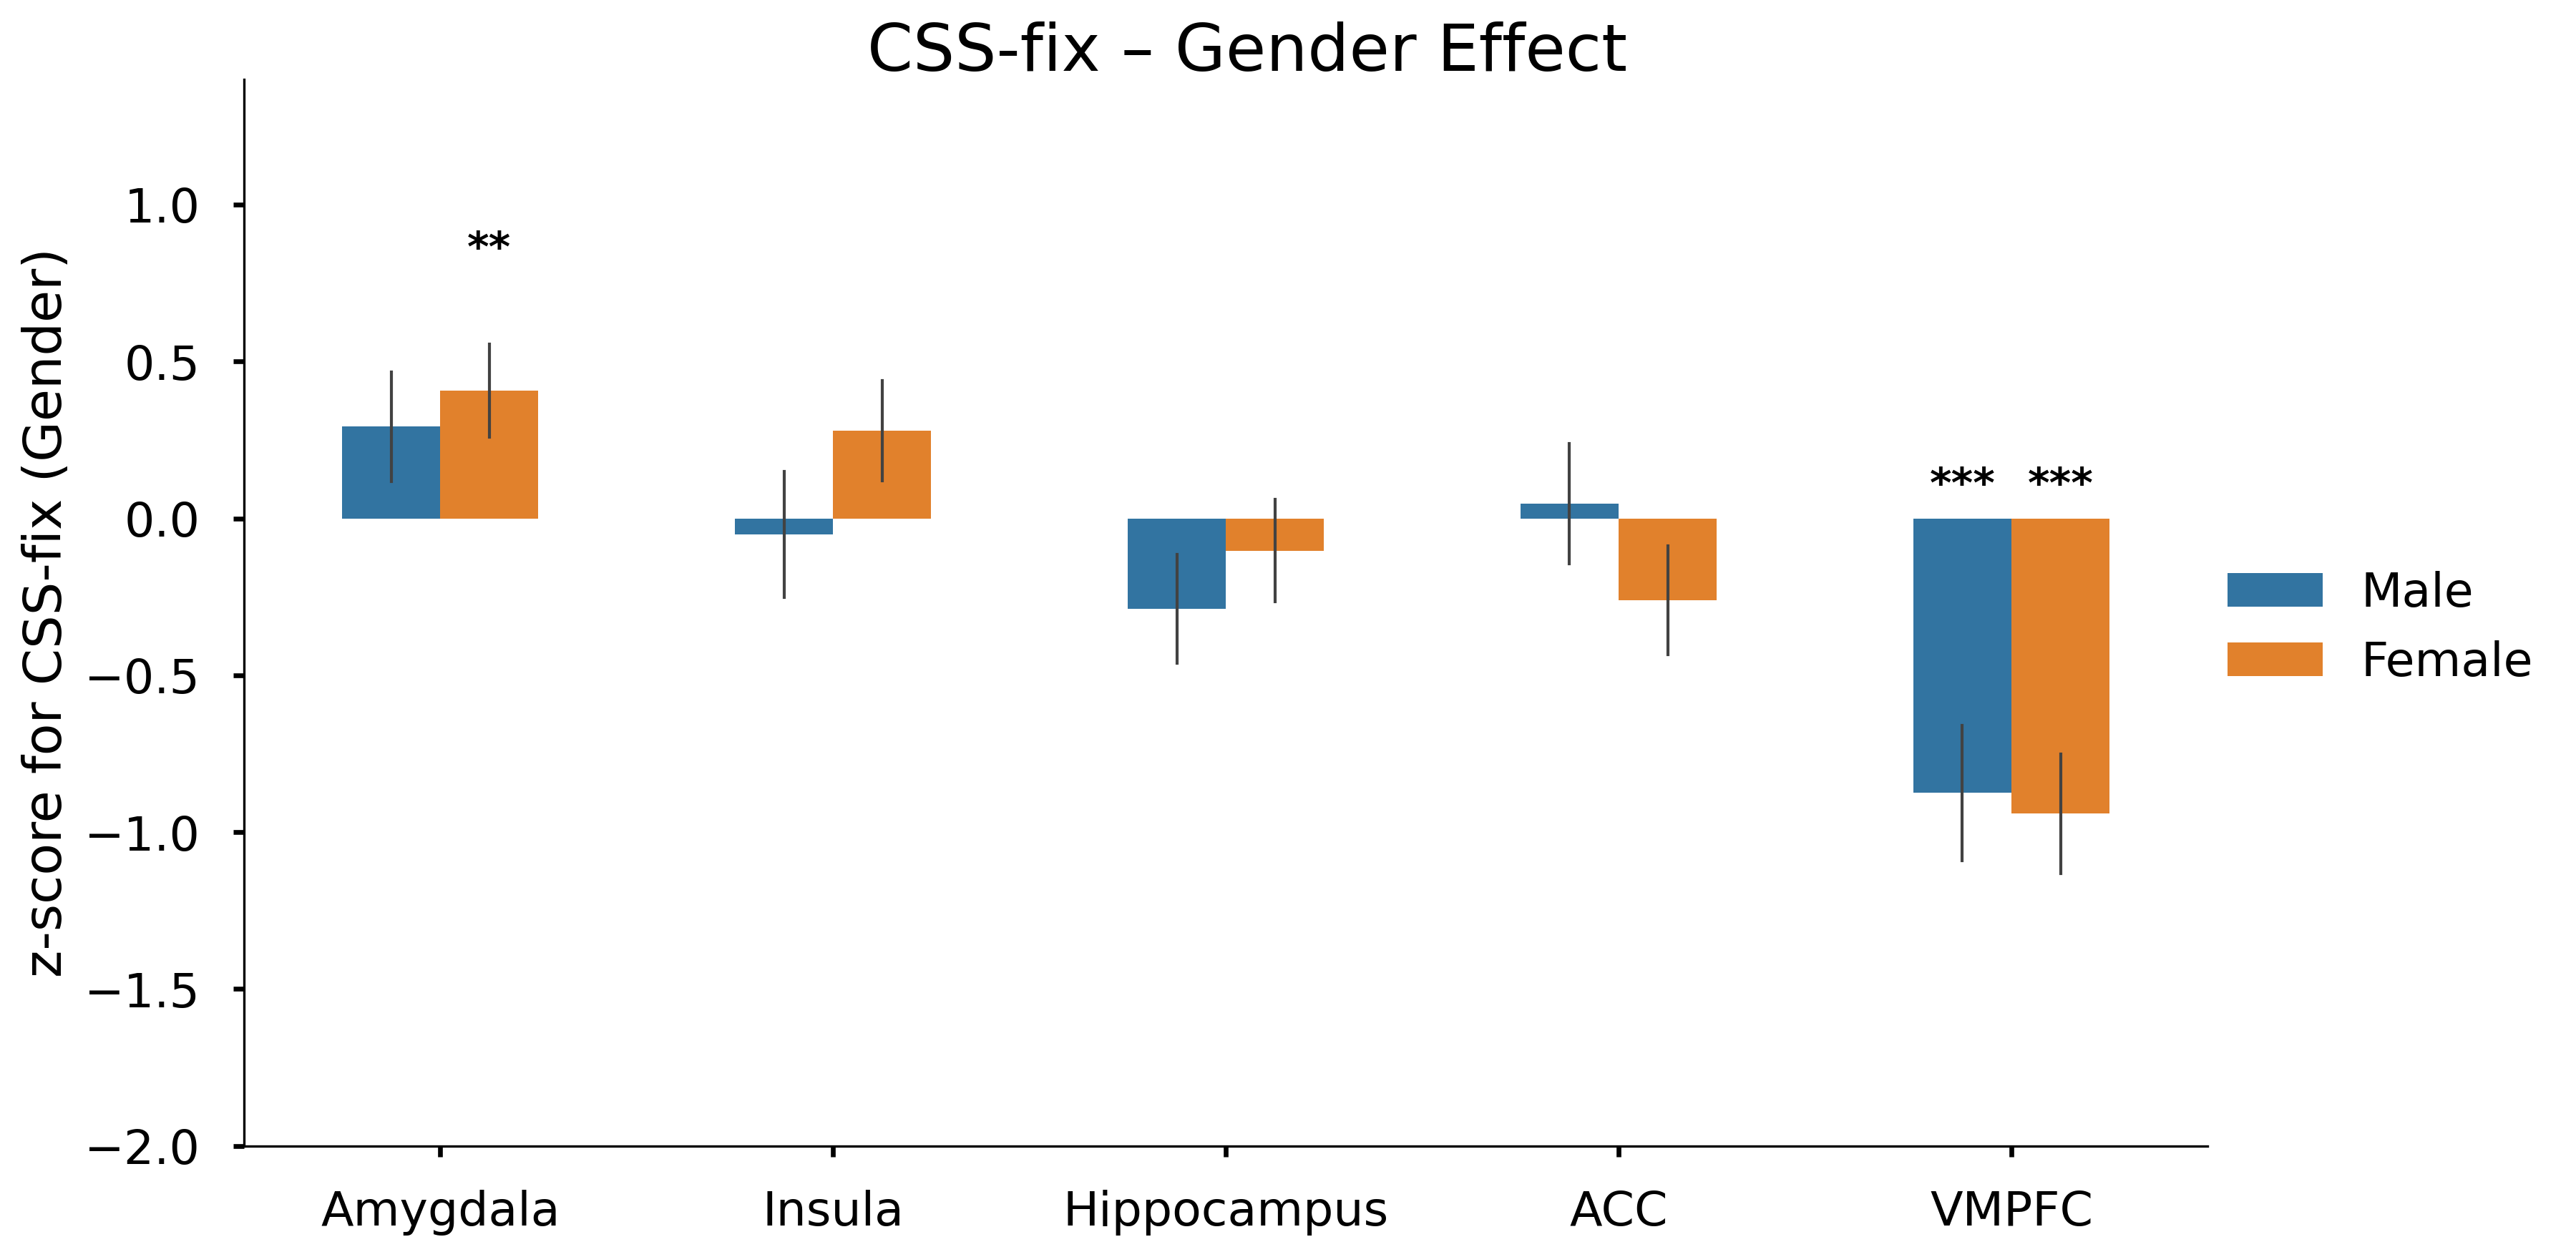


===== Gender main effect: CSminus-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.134     0.58    98    0.561      
Insula          Gender[T.Female]                                       -0.197    -0.68    98    0.501      
Hippocampus     Gender[T.Female]                                        0.336     1.34    98    0.184      
ACC             Gender[T.Female]                                       -0.292    -1.01    98    0.314      
VMPFC           Gender[T.Female]                                        0.219     0.78    98    0.435      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level               

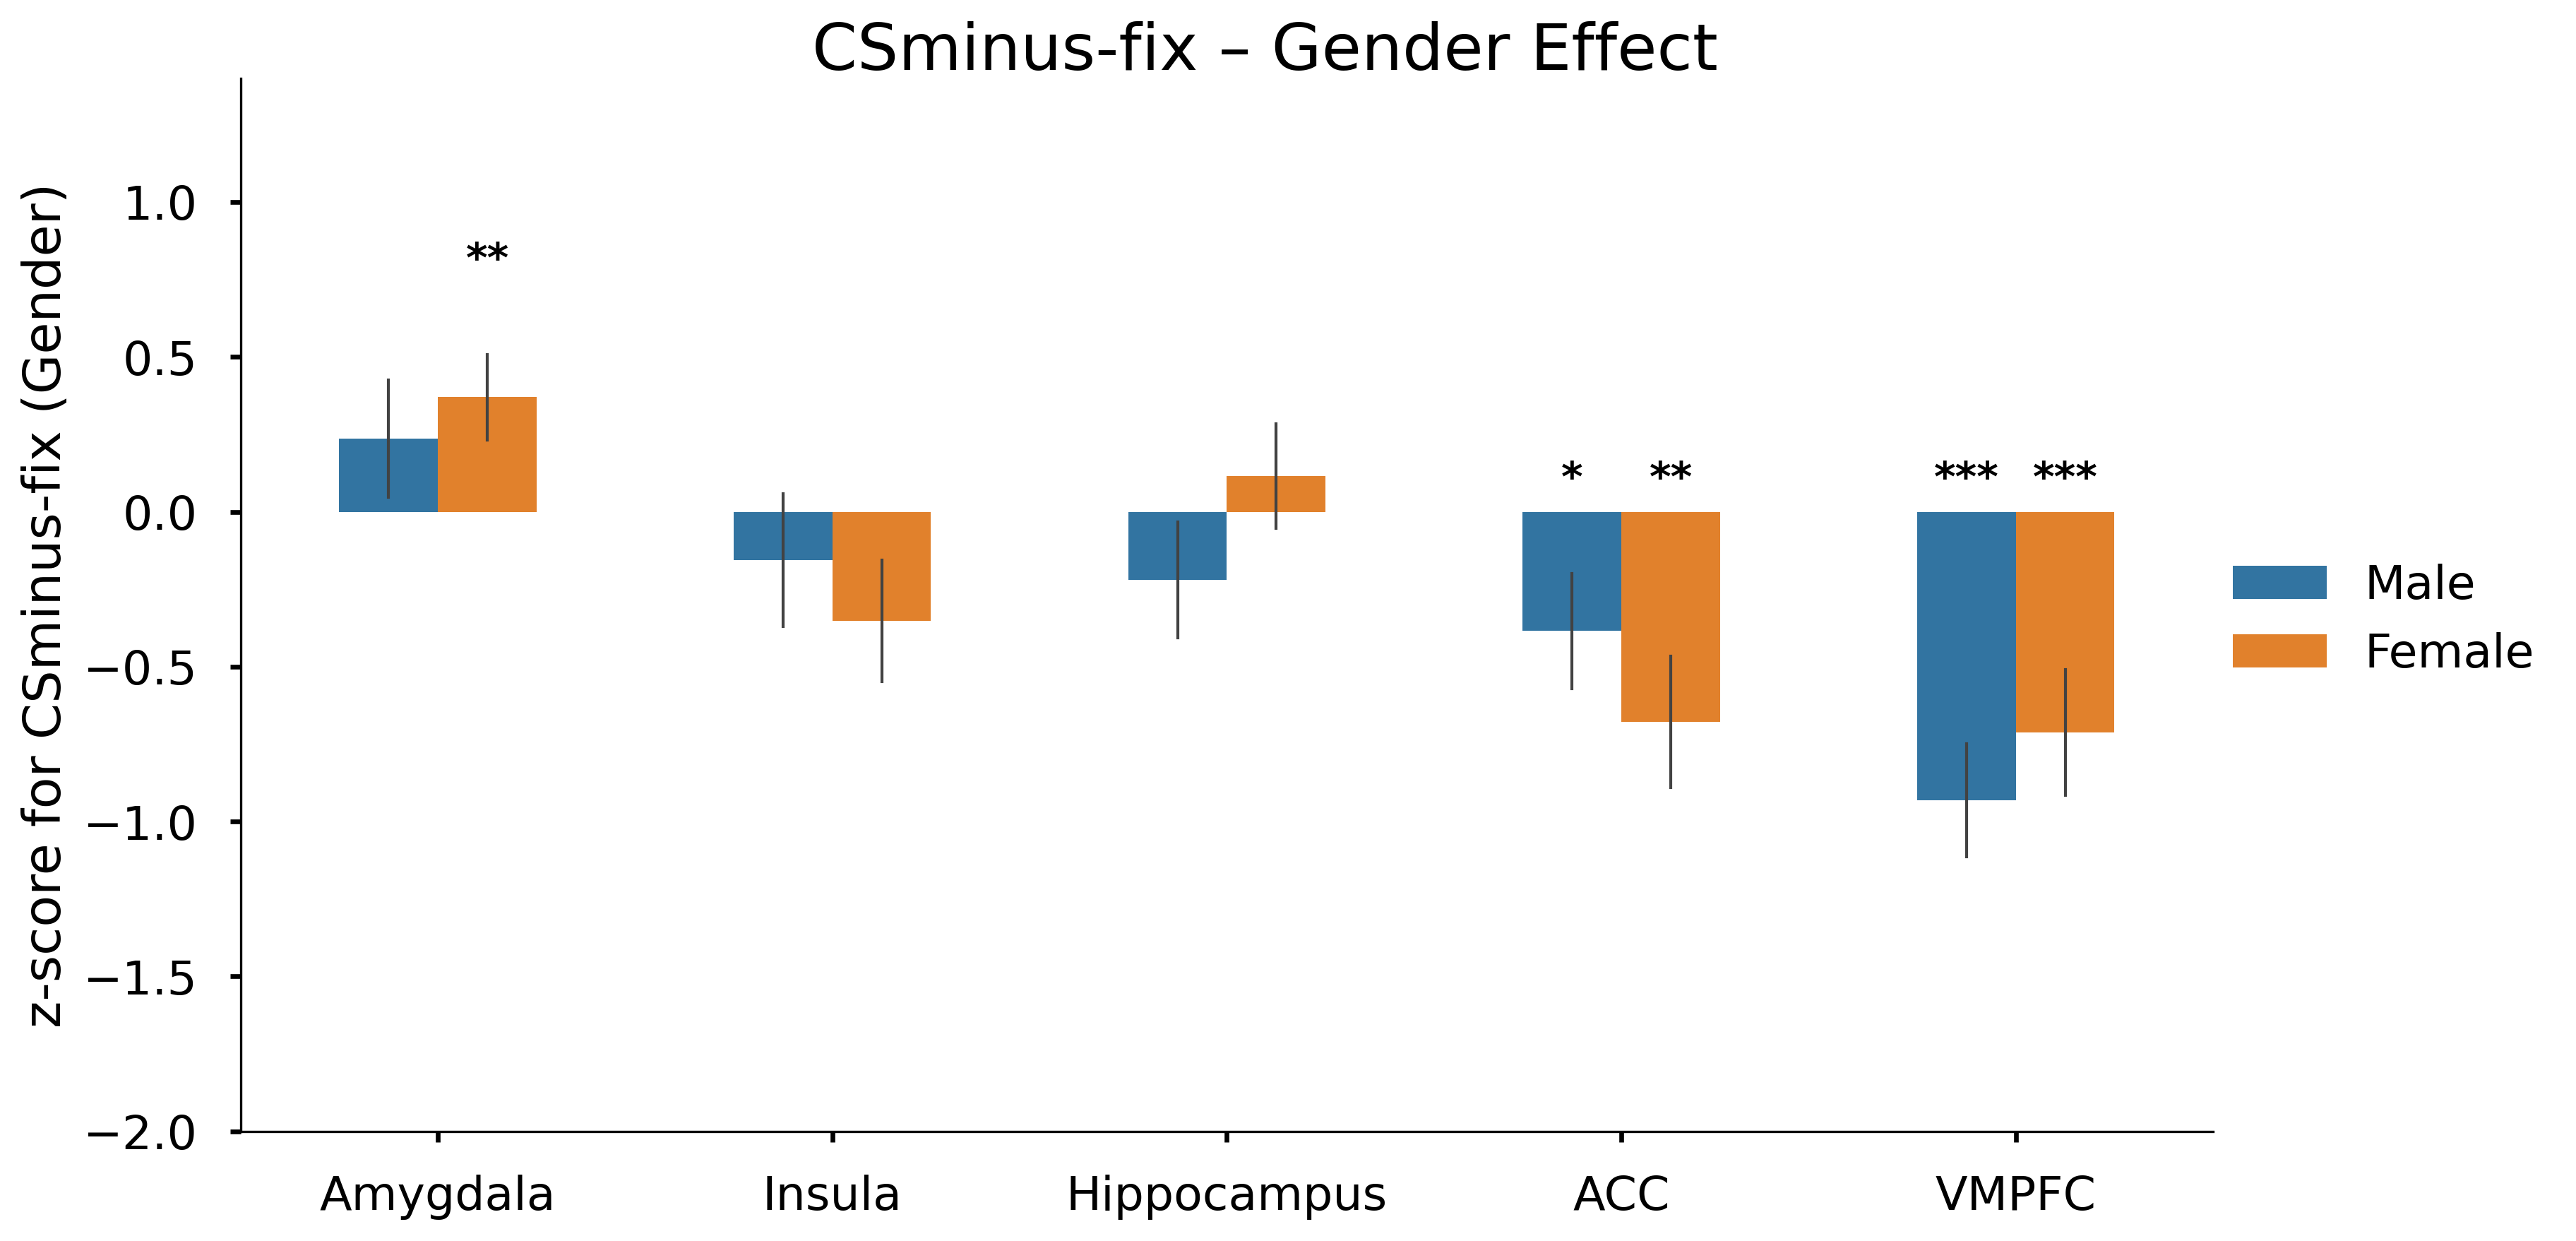

In [11]:
# ---------------------------------------------------------
# 3️⃣ Gender main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Gender main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Gender',
        order=ROI_list, kind='bar', errorbar='se', height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Gender")[0])

    g.set_axis_labels('', f'z-score for {contrast} (Gender)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Gender Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Gender_sig.png', bbox_inches='tight')
    plt.show()


===== Group × Gender interaction: CSR-CSS =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.566     1.21    96    0.229      
Insula          Group[T.HC]:Gender[T.Female]                           -0.009    -0.02    96    0.986      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.028     2.03    96    0.046     *
ACC             Group[T.HC]:Gender[T.Female]                           -0.296    -0.58    96    0.562      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.157    -0.29    96    0.776      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

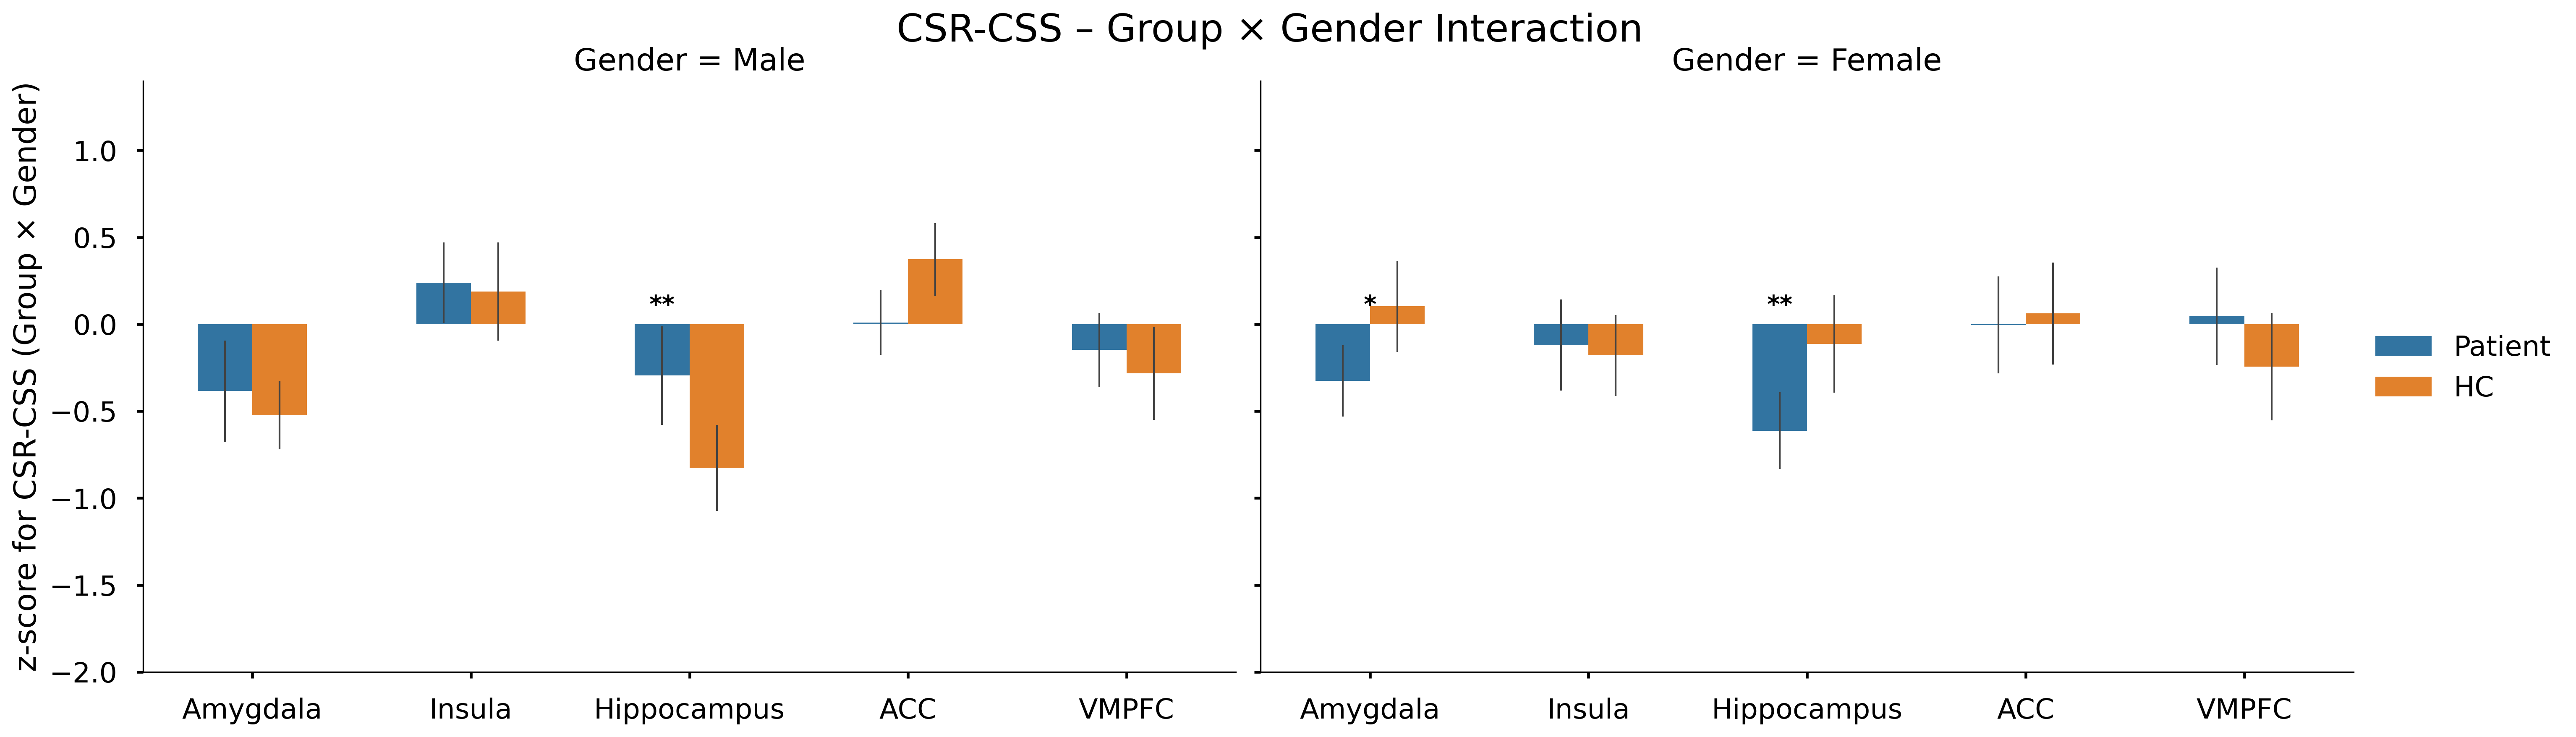


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.2288      
Insula              0.9861      
Hippocampus         0.0456     *
ACC                 0.5622      
VMPFC               0.7762      
-----------------------------------


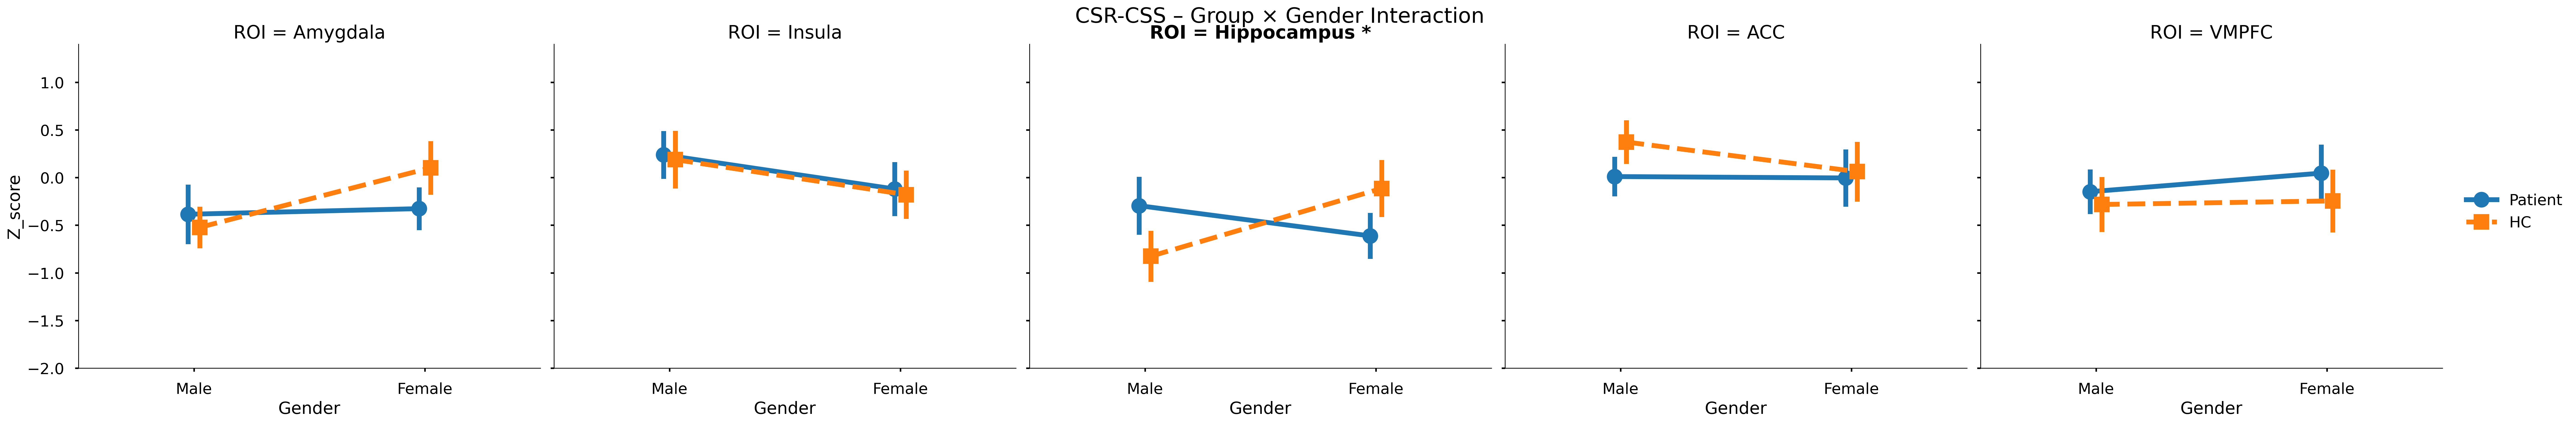


===== Group × Gender interaction: CSR-CS- =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.540     1.16    96    0.249      
Insula          Group[T.HC]:Gender[T.Female]                           -0.632    -1.10    96    0.275      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.052     1.79    96    0.076      
ACC             Group[T.HC]:Gender[T.Female]                           -0.261    -0.46    96    0.649      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.313     0.53    96    0.599      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

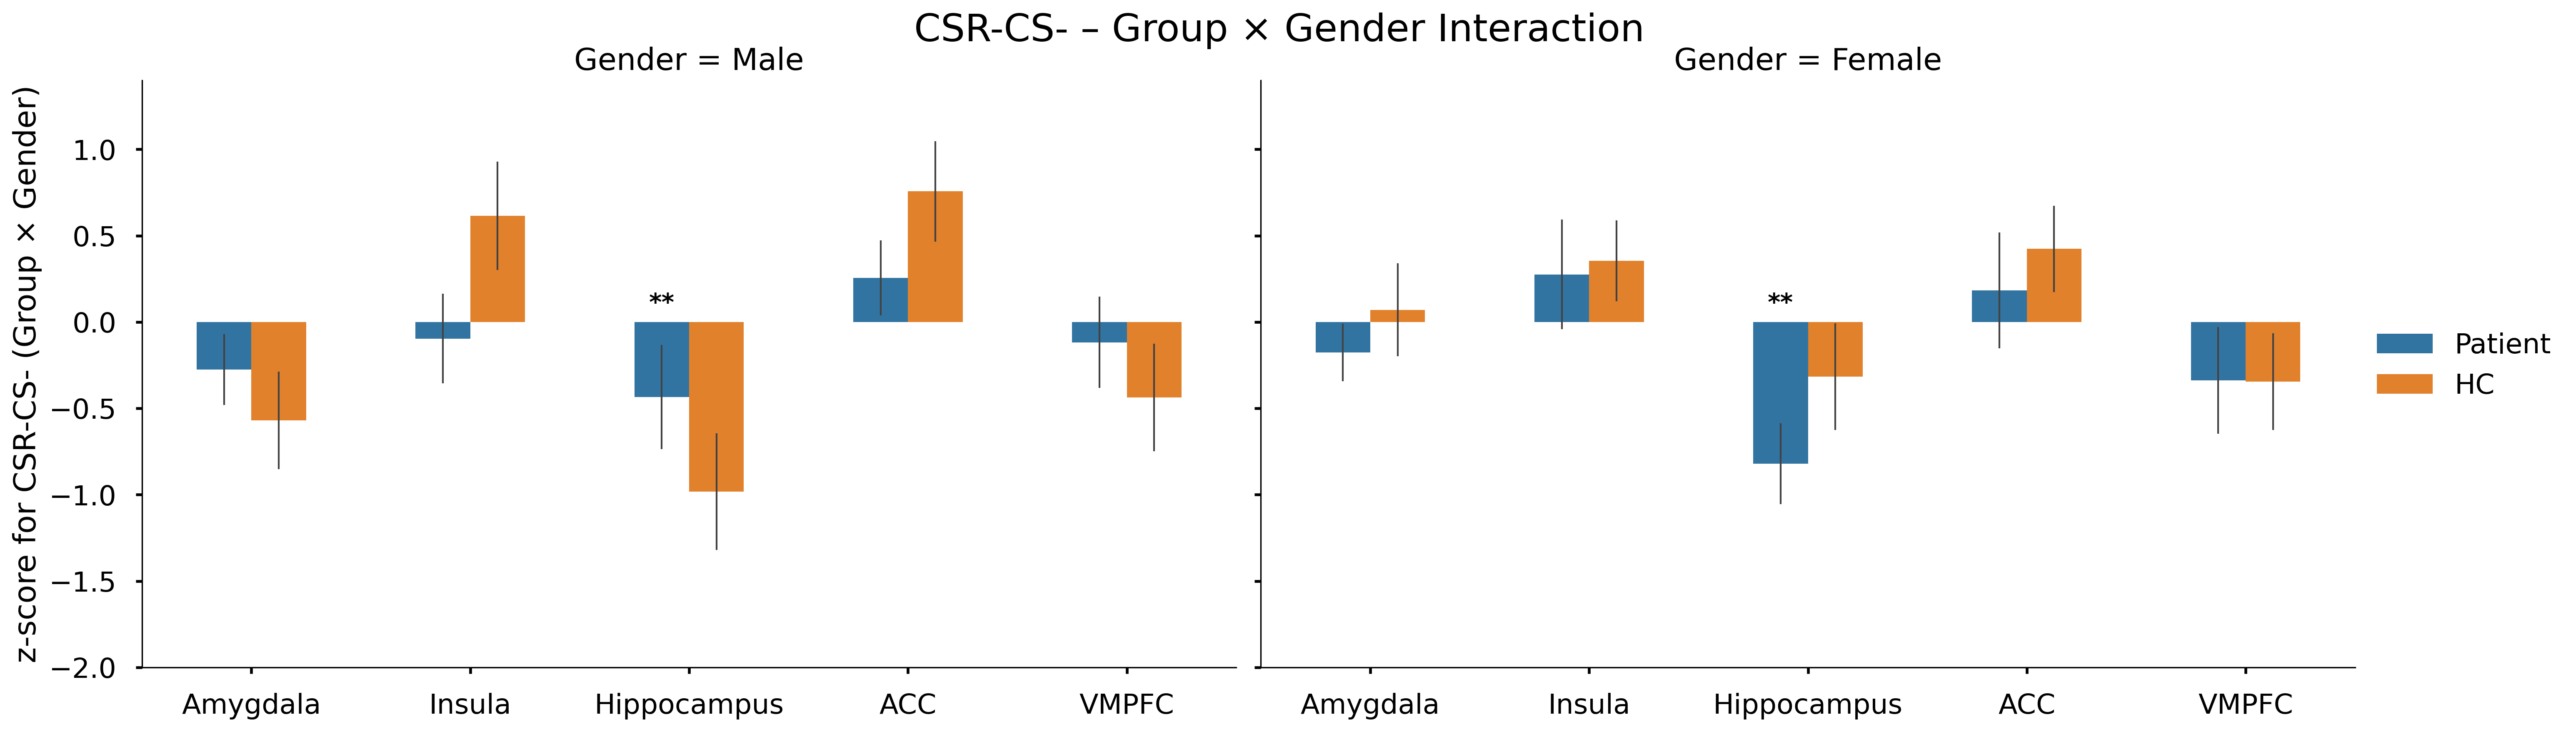


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.2494      
Insula              0.2751      
Hippocampus         0.0761      
ACC                 0.6491      
VMPFC               0.5987      
-----------------------------------


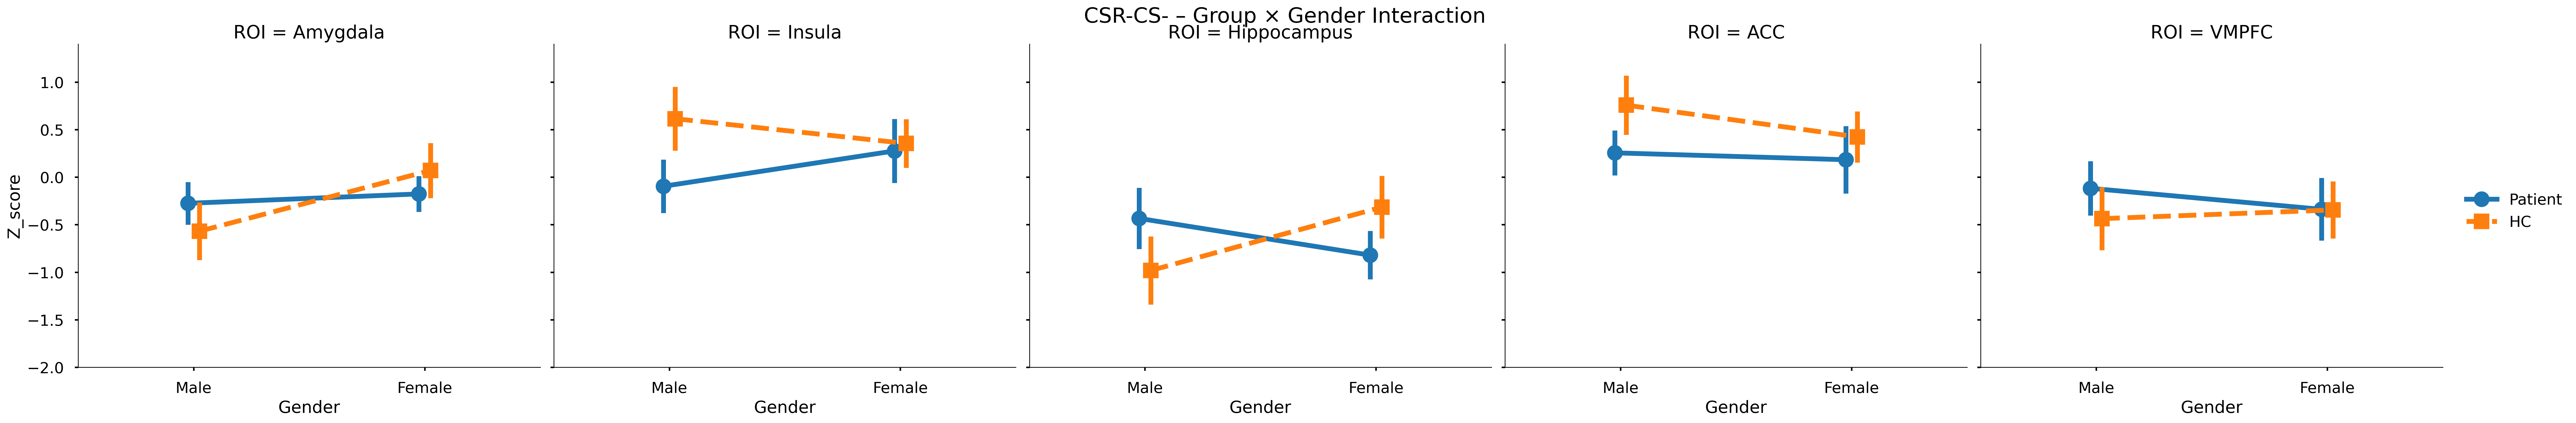


===== Group × Gender interaction: CSS-CS- =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                           -0.072    -0.16    96    0.873      
Insula          Group[T.HC]:Gender[T.Female]                           -0.583    -1.02    96    0.308      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.071    -0.14    96    0.887      
ACC             Group[T.HC]:Gender[T.Female]                            0.080     0.15    96    0.884      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.496     0.92    96    0.359      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

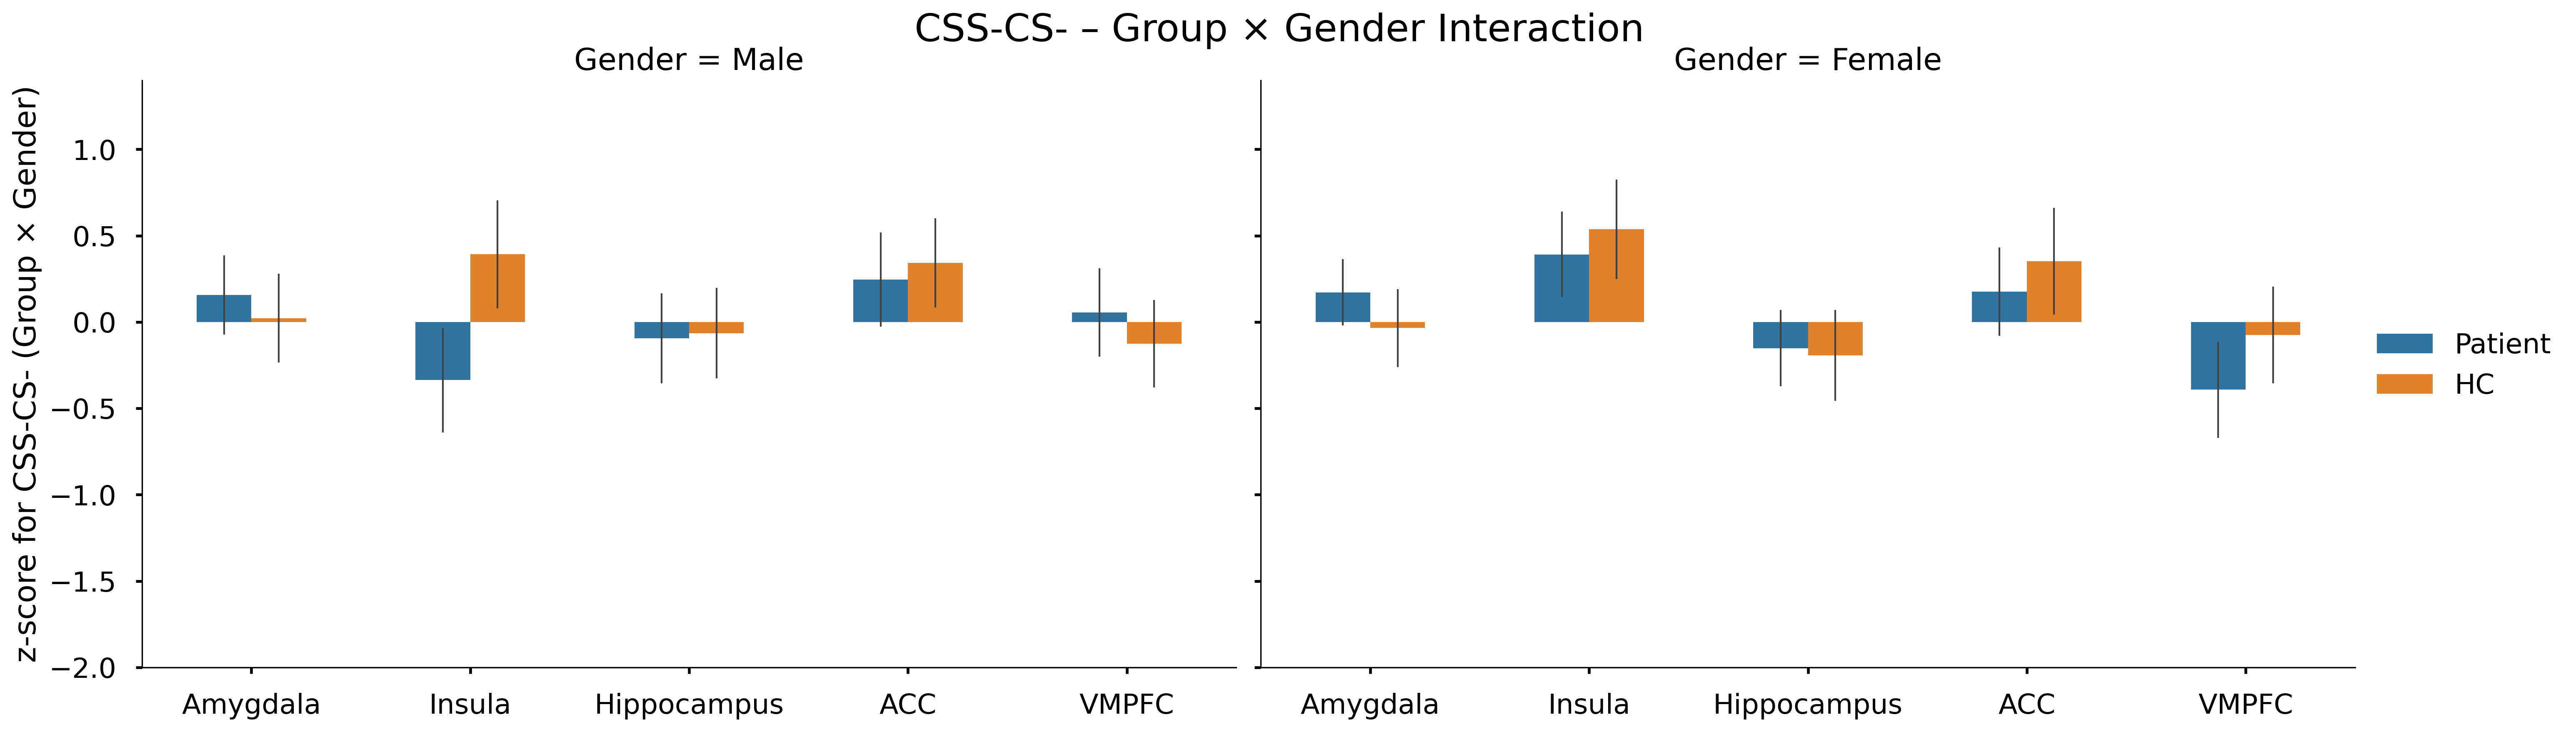


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.8726      
Insula              0.3084      
Hippocampus         0.8868      
ACC                 0.8838      
VMPFC               0.3591      
-----------------------------------


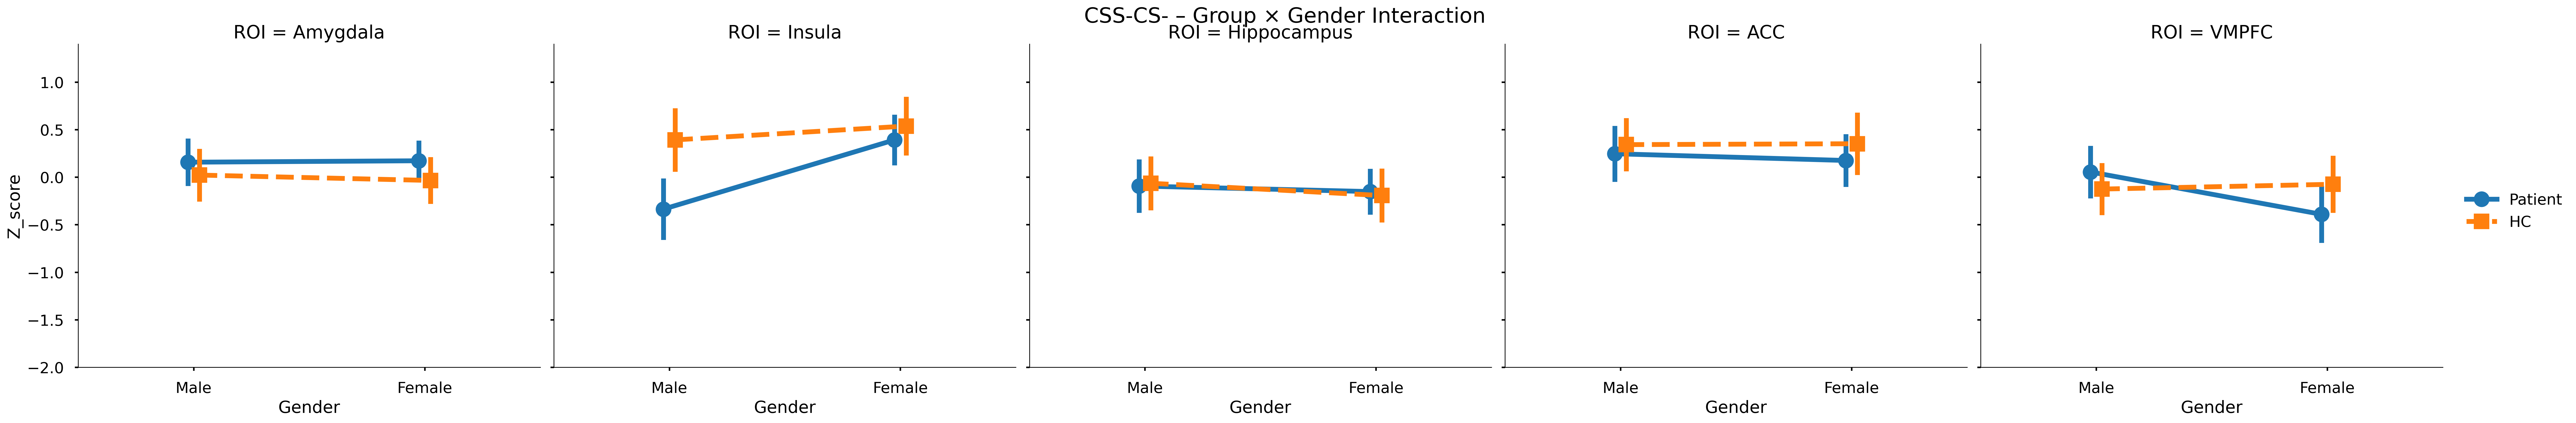


===== Group × Gender interaction: CSR-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.881     1.75    96    0.083      
Insula          Group[T.HC]:Gender[T.Female]                           -0.127    -0.26    96    0.796      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.224     2.12    96    0.037     *
ACC             Group[T.HC]:Gender[T.Female]                           -0.378    -0.66    96    0.508      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.430     0.74    96    0.463      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

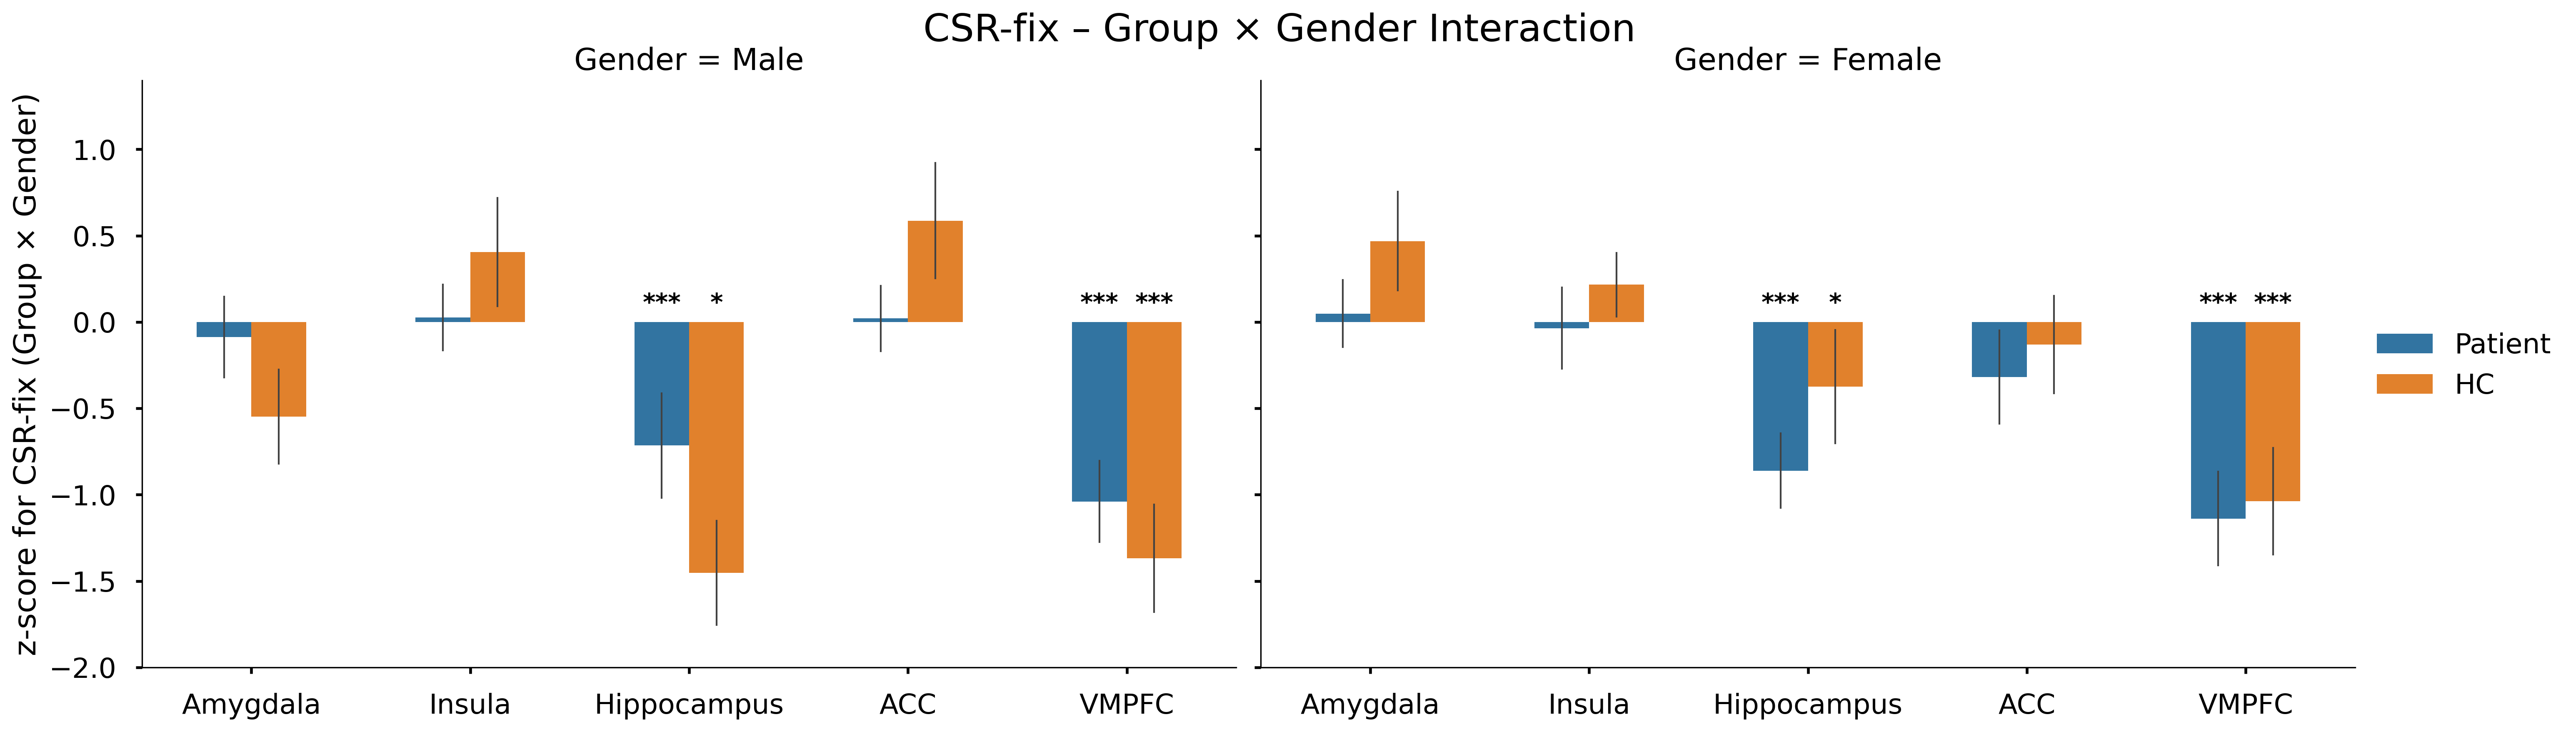


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.0829      
Insula              0.7955      
Hippocampus         0.0368     *
ACC                 0.5084      
VMPFC               0.4634      
-----------------------------------


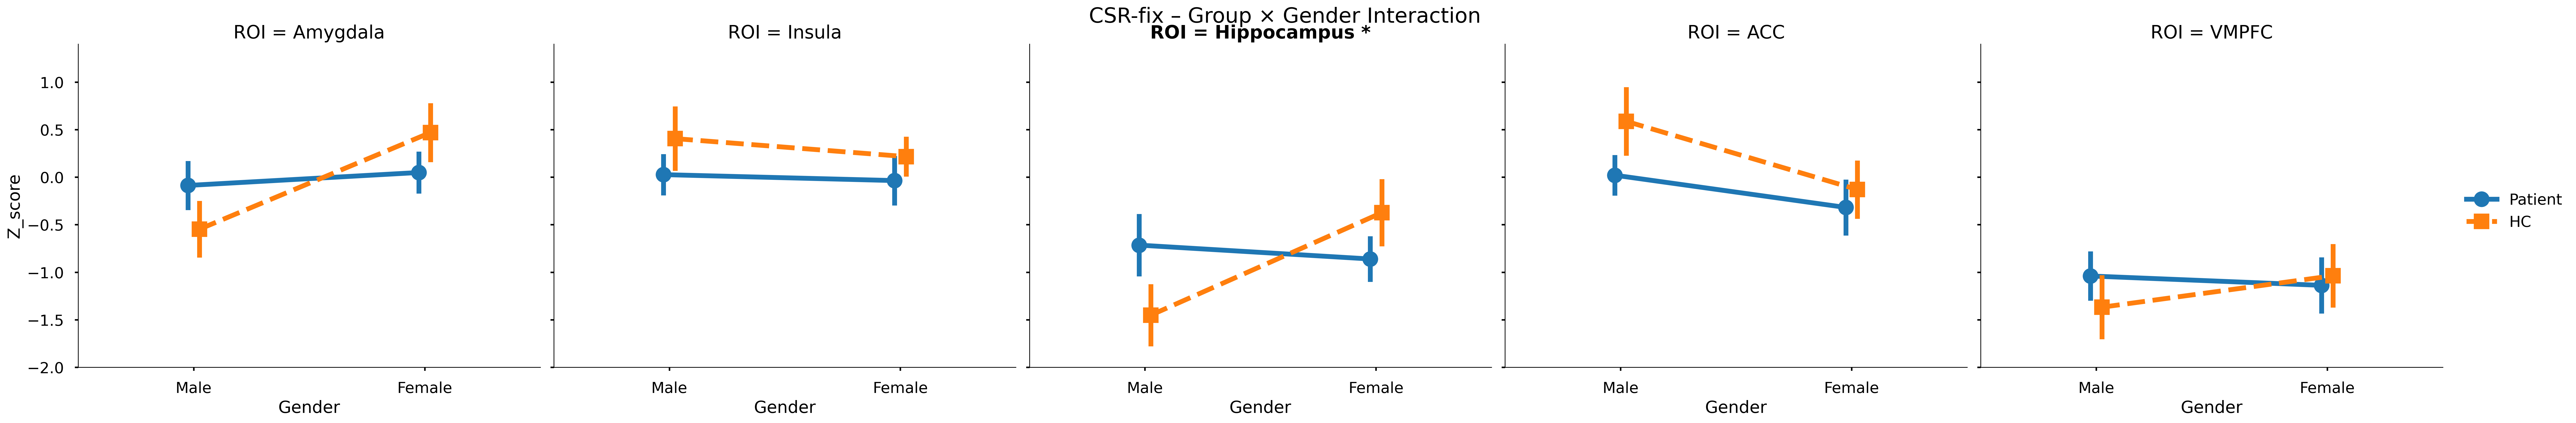


===== Group × Gender interaction: CSS-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.085     0.19    96    0.853      
Insula          Group[T.HC]:Gender[T.Female]                           -0.106    -0.21    96    0.834      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.201    -0.42    96    0.678      
ACC             Group[T.HC]:Gender[T.Female]                            0.030     0.06    96    0.955      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.622     1.08    96    0.285      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

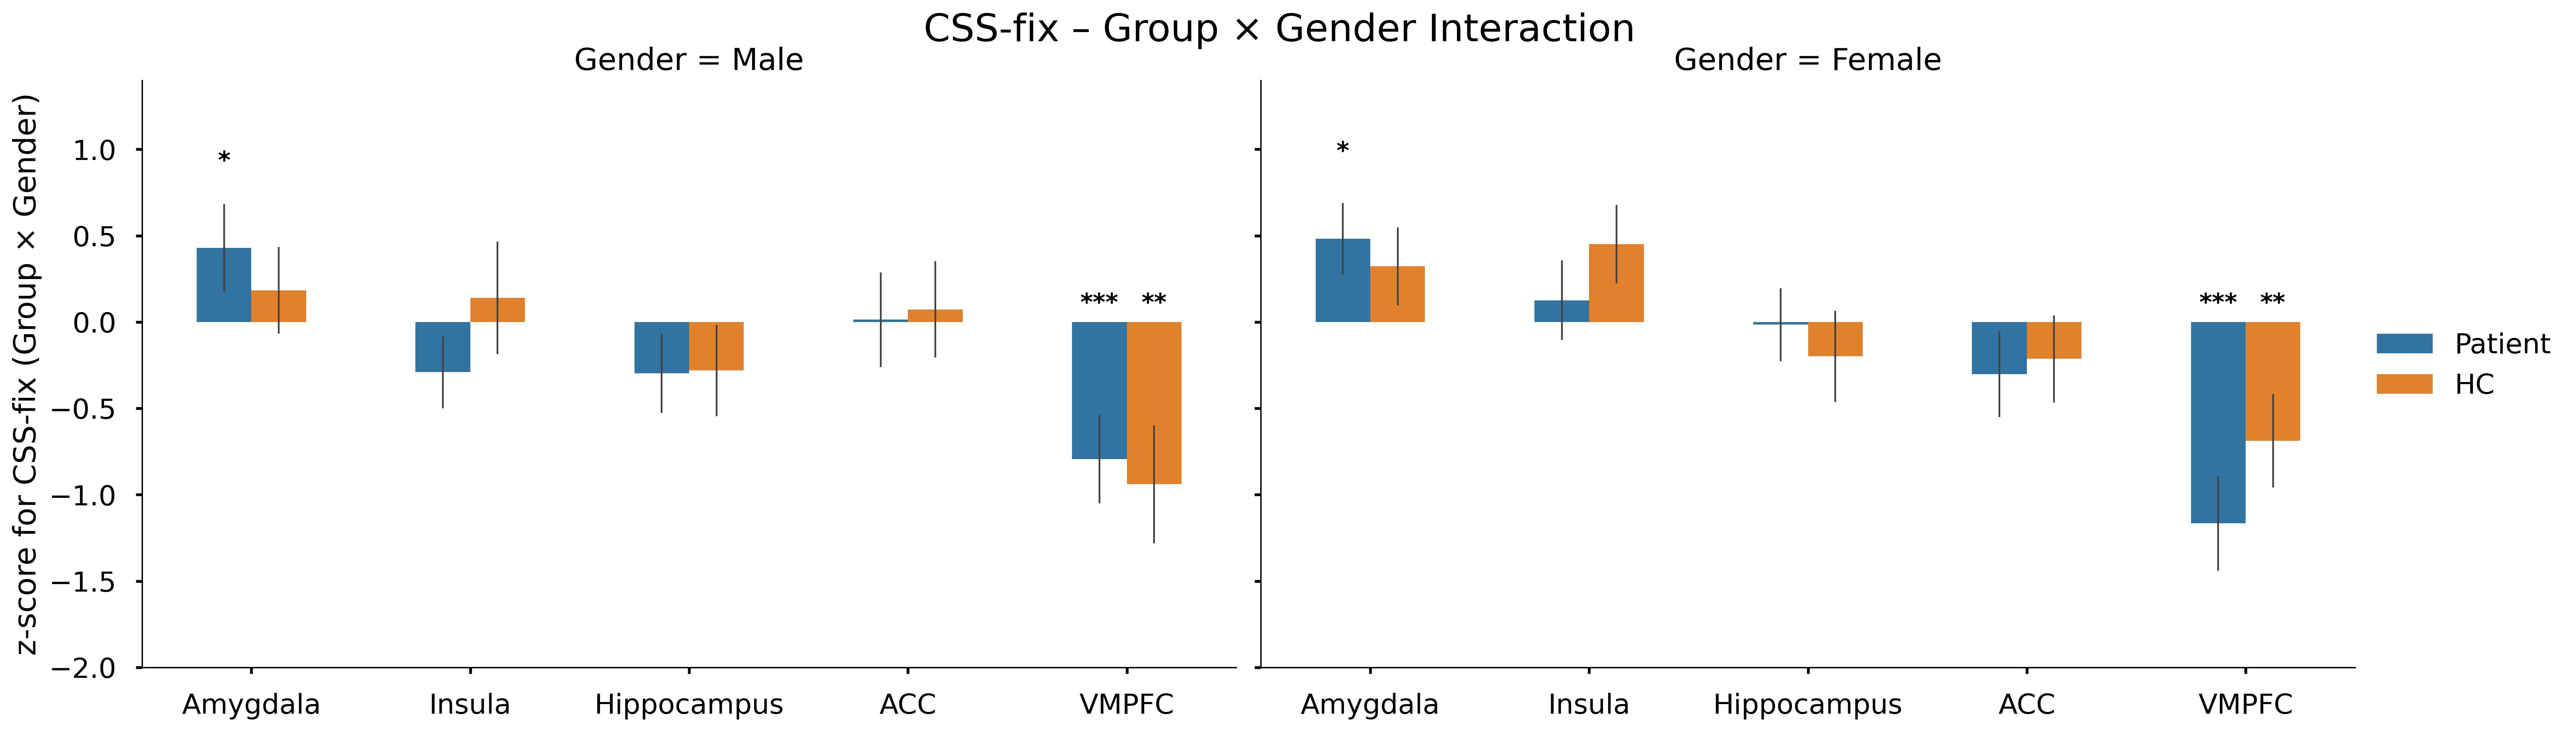


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.8529      
Insula              0.8342      
Hippocampus         0.6782      
ACC                 0.9545      
VMPFC               0.2846      
-----------------------------------


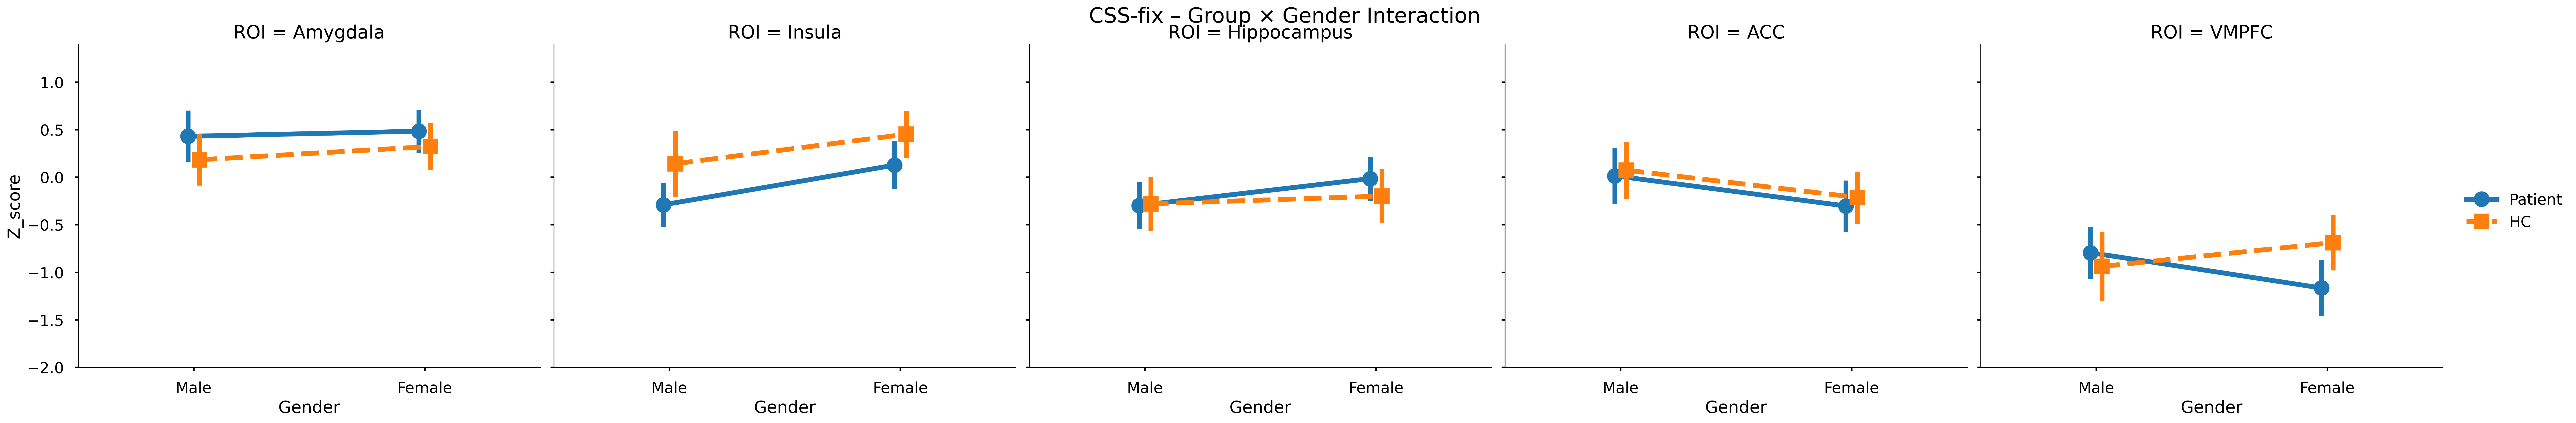


===== Group × Gender interaction: CSminus-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.220     0.47    96    0.638      
Insula          Group[T.HC]:Gender[T.Female]                            0.726     1.24    96    0.218      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.124    -0.24    96    0.807      
ACC             Group[T.HC]:Gender[T.Female]                           -0.058    -0.10    96    0.921      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.011     0.02    96    0.984      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender

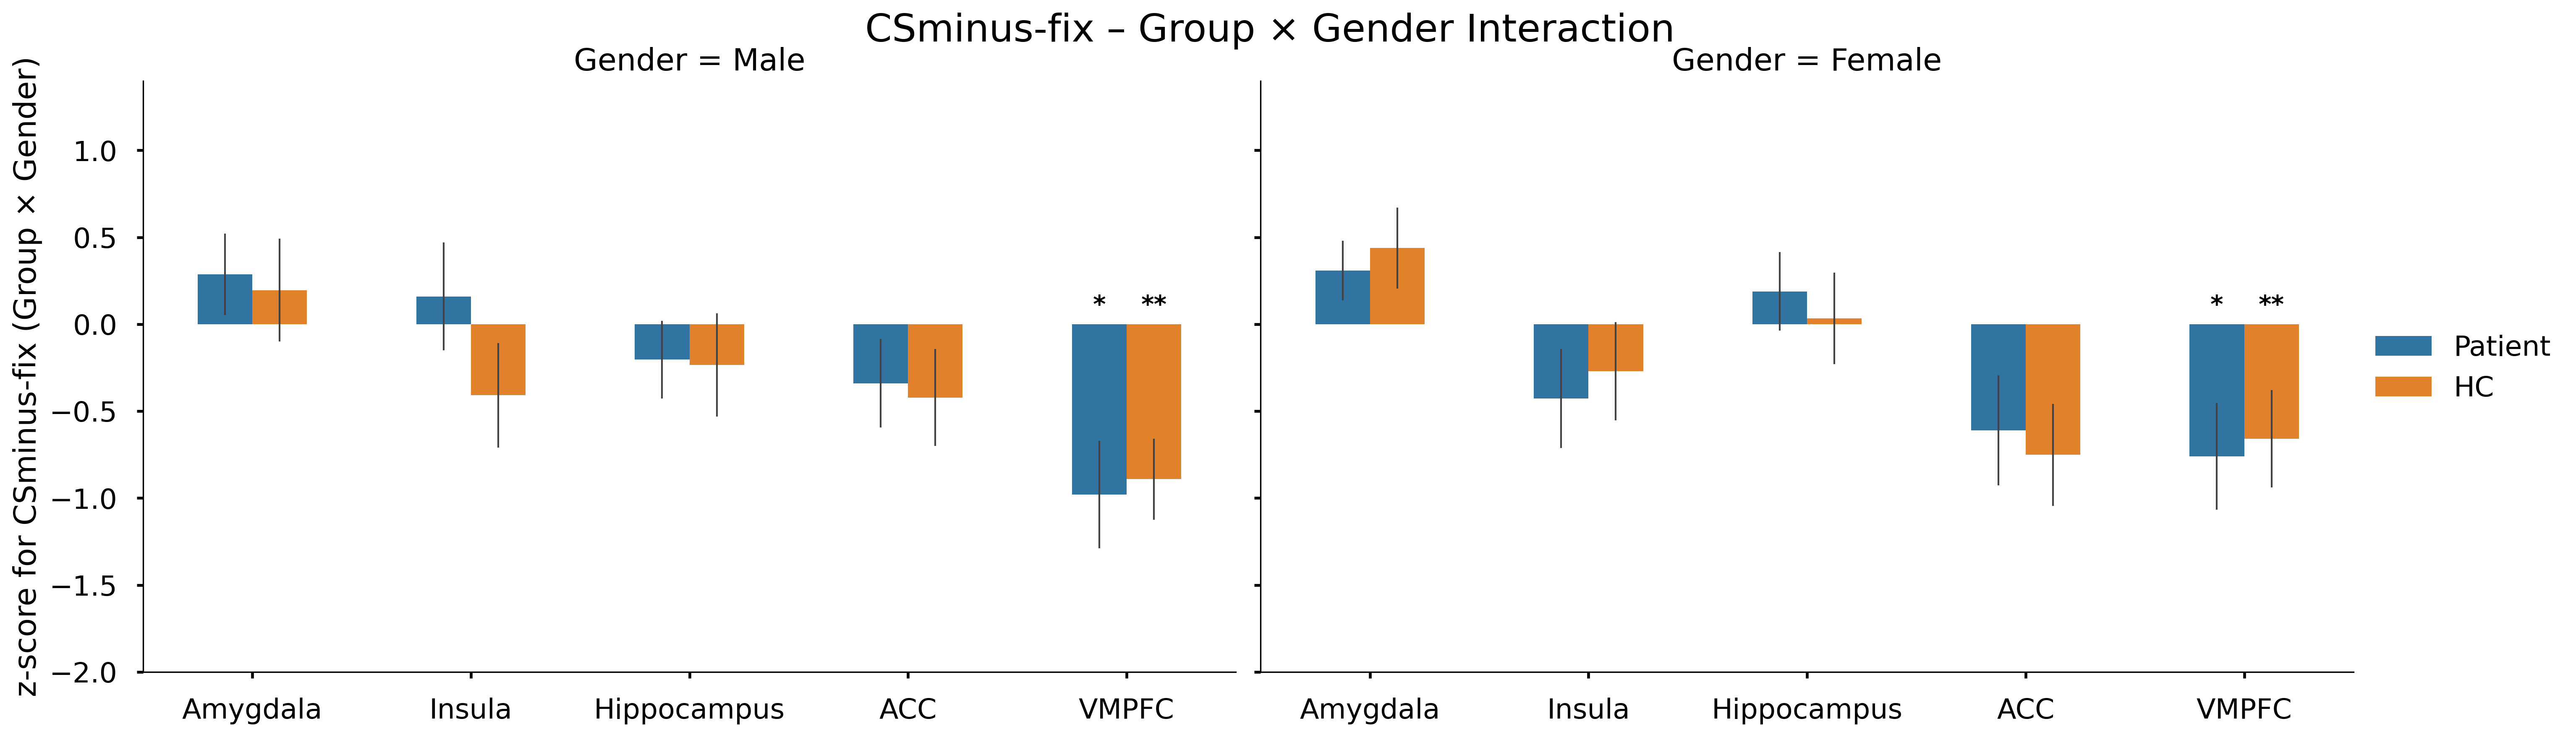


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.6378      
Insula              0.2178      
Hippocampus         0.8072      
ACC                 0.9207      
VMPFC               0.9842      
-----------------------------------


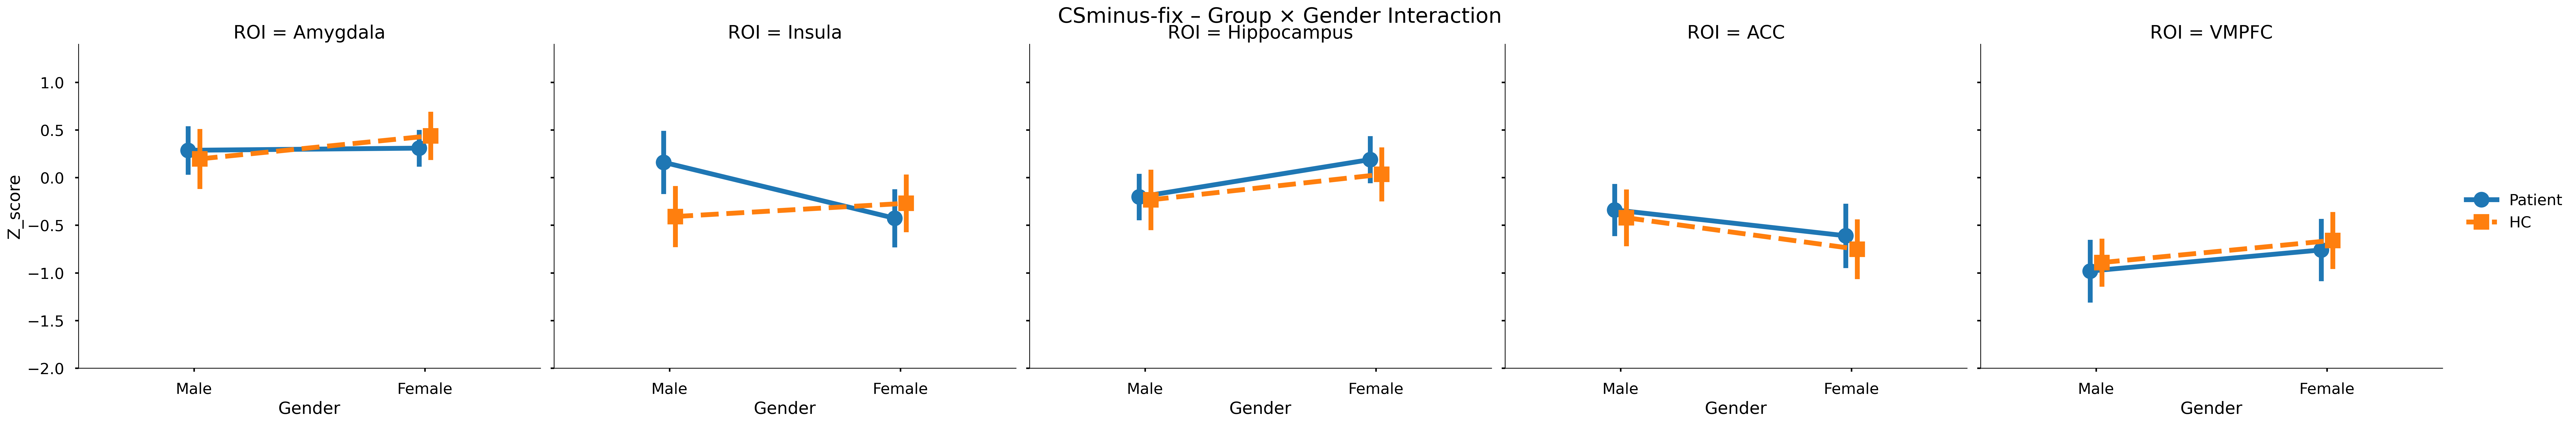

In [12]:
interaction_terms = get_matching_model_terms(model, "two_way")

for term in interaction_terms:
    var1, var2 = extract_factors_from_term(term)
    for contrast in contrast_list:
        print(f"\n===== {var1} × {var2} interaction: {contrast} =====")
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Phase'] == 'phase2')]

        g = sns.catplot(
            x='ROI', y='Z_score', hue=var1, col=var2,
            order=ROI_list,
            kind='bar', errorbar='se',
            height=6, aspect=1.6, width=0.5,
            err_kws={'linewidth': 1},
            data=df
        )

        for ax in g.axes.flat:
            add_sig_stars(ax, df, ROI_list, term)

        g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

        #line plots
        g = sns.catplot(
            data=df,
            x='Gender', y='Z_score', hue='Group',
            col='ROI',
            kind='point',         # line plot (mean + SE)
            errorbar='se',        # ✅ correct for seaborn ≥0.12
            dodge=True,
            markers=['o', 's'],
            linestyles=['-', '--'],
            height=6, aspect=1.2
        )
        add_sig_stars_lineplot_interaction(
            g.axes, df, ROI_list, "Group[T.HC]:Gender[T.Female]"
        )
        #g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/line_{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()